In [319]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
from scipy import stats
rng = np.random.default_rng()
from matplotlib.colors import ListedColormap
pd.options.mode.chained_assignment = None  # default='warn'
import itertools
import geopandas as gpd
from utils import paths
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [320]:
#### THINGS TO CHANGE ARE ALL HERE:
output_anomalies_run_name = 'RF_DT_targetscaled'
original_run_name = 'RF_DT_targetscaled'
r2_thresh = 0.7
ks_sig_thresh = 0.01
num_events_per_site_thresh = 4
pre_site_ks_filter = False



In [321]:
# palettes
ks_colors = ['#4d5ea1', '#a14d57', '#9171AB']


In [322]:

# Pull in original data from RF
performance = pd.read_csv(f'runs/RF/{original_run_name}/performance.csv').rename(columns = {"test_score":"R2"})
event_original = pd.read_csv(f'runs/RF/{original_run_name}/event.csv')
test = pd.read_csv(f'runs/RF/{original_run_name}/test.csv')


# Pull in data with extra columns added (and bootstrapping performed) from folder: output_anomalies
event_original = pd.read_csv('output_anomalies/' + output_anomalies_run_name + '_event.csv')
uncertainty = pd.read_csv('output_anomalies/' + output_anomalies_run_name + '_testuncertainty.csv')

# Print information about performance 
performance_keep = performance[performance['R2'] >= r2_thresh]
dropped_sites = [i for i in performance.SITE_ID.unique() if i not in performance_keep.SITE_ID.unique()]
print(f"{len(dropped_sites)} sites removed for R2 < {r2_thresh}: {dropped_sites}.")
print(f"{len(performance_keep)} sites remaining.")
remaining_sites = performance_keep.SITE_ID.unique()

# Restrict to sites that meet r2_thresh
event_original = event_original[event_original['SITE_ID'].isin(remaining_sites)]
test = test[test['SITE_ID'].isin(remaining_sites)]


# Pull in metadata (created in e_analysis.ipynb)
meta = pd.read_csv('metadata_total.csv')
nan_columns = meta.columns[meta.isna().all()].tolist()
print(f"Metadata with no info: {nan_columns}")

# Merge performance with meta
meta = meta.merge(performance_keep[['SITE_ID', 'R2']], how = 'left', on = 'SITE_ID')

# ratio of event to testing days
num_event_days = event_original.groupby("SITE_ID")['actual - predicted'].count().reset_index()
num_test_days = test.groupby('SITE_ID')['day'].count().reset_index()
temp_num_days = num_event_days.merge(num_test_days, how = 'left', on = 'SITE_ID')
temp_num_days['event_over_test_days'] = (temp_num_days['actual - predicted'] / (temp_num_days['day']*4))*100
temp_num_days['num_event_days'] = temp_num_days['actual - predicted']
meta = meta.merge(temp_num_days[['SITE_ID', 'event_over_test_days', 'num_event_days']], how = 'left', on = 'SITE_ID')

meta['aridity_new'] = meta['PET'] / meta['MAP_y']

# calculate porosity from bulk density
particle_density = 2.65 #g/cm3
meta['porosity'] = (1 - (meta['bdod_mean_alldepth'] / particle_density)) * 100

# growing season GPP average and mean LAI for scatter plot normalization
grow_season = pd.read_csv('output_findevents/v3/allsites_training_dd_clipped.csv')
grow_season_mean = grow_season.groupby('SITE_ID')['GPP_DT_VUT_REF'].mean().reset_index().rename(columns= {"GPP_DT_VUT_REF":"mean_gpp"})
grow_season_std = grow_season.groupby('SITE_ID')['GPP_DT_VUT_REF'].std().reset_index().rename(columns= {"GPP_DT_VUT_REF":"std_gpp"})
mean_lai = grow_season.groupby("SITE_ID")['LAI'].mean().reset_index().rename(columns = {"LAI":"mean_lai"})
mean_lai = mean_lai[mean_lai['mean_lai'] < 23]
meta = meta.merge(grow_season_mean, how = 'left', on = 'SITE_ID')
meta = meta.merge(grow_season_std, how = 'left', on = 'SITE_ID')
meta = meta.merge(mean_lai, how = 'left', on = 'SITE_ID')

# water table depths
wtd = pd.read_csv('wtds.csv')
meta = meta.merge(wtd[['SITE_ID', 'continent', 'WTD']], how = 'left', on = 'SITE_ID')





24 sites removed for R2 < 0.7: ['IT-Tor', 'DE-Gri', 'NL-Loo', 'AU-GWW', 'CH-Oe1', 'RU-Fyo', 'CH-Dav', 'CA-TP4', 'DE-Obe', 'BE-Vie', 'CH-Lae', 'AU-Rob', 'GF-Guy', 'IT-Lav', 'CH-Cha', 'CA-NS7', 'CA-SF1', 'CA-SF3', 'CA-SF2', 'DE-Hai', 'CA-NS1', 'DE-Tha', 'CN-Sw2', 'CA-NS3'].
58 sites remaining.
Metadata with no info: []


In [323]:
# Get rid of columns that start with "unnamed"
event_original = event_original.loc[:, ~event_original.columns.str.contains('^Unnamed')]
meta = meta.loc[:, ~meta.columns.str.contains('^Unnamed')]
uncertainty = uncertainty.loc[:, ~uncertainty.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

# Merge events with  metadata
event = event_original.merge(meta, how = 'left', on = 'SITE_ID')

# Normalize event by mean_gpp
event['anomaly_norm_gpp'] = (event['actual - predicted (bootstrapped)'] - event['mean_gpp']) / event['std_gpp']

# How many starting events
num_all_events = event.shape[0]
print(f"Total number of events: {num_all_events}")

Total number of events: 1629


In [324]:

# Get a dataframe of pre-storm soil moisture conditions

def load_data(site_id):
    dd_data = pd.read_csv(os.path.join(paths.FLUXNET_DD_DIR, site_id + '.csv'), parse_dates = ['TIMESTAMP'])
    dd_data['TIMESTAMP'] = pd.to_datetime(dd_data['TIMESTAMP'])
    dd_data['SITE_ID'] = site_id
    return dd_data

site_name, storm_start, pre_storm_swc = [], [], []
for site in event.SITE_ID.unique():
    temp = event[event['SITE_ID'] == site]
    dd_data = load_data(site)
    dd_data = dd_data.set_index('TIMESTAMP')

    temp['storm_start'] = pd.to_datetime(temp['storm_start'])
    for idx, row in temp.iterrows():
        storm_start_day = row['storm_start']
        swc_day = storm_start_day - timedelta(days=5)
        site_name.append(site)
        storm_start.append(storm_start_day)
        pre_storm_swc.append(dd_data.loc[swc_day, 'SWC_F_MDS_1'])

pre_storm_swcs = pd.DataFrame({'SITE_ID':site_name, 'storm_start':storm_start, 'pre_storm_swc':pre_storm_swc})

# Drop duplicates for each storm/site combination
print(f"Shape before dropping duplicates: {pre_storm_swcs.shape}")
pre_storm_swcs = pre_storm_swcs.drop_duplicates(subset = ['SITE_ID', 'storm_start'])
print(f"Shape after dropping duplicates: {pre_storm_swcs.shape}")

# Merge with event dataframe
event['storm_start'] = pd.to_datetime(event['storm_start'])
event = event.merge(pre_storm_swcs, how = 'left', on = ['SITE_ID', 'storm_start'])



Shape before dropping duplicates: (1629, 3)
Shape after dropping duplicates: (533, 3)


### Exclude extreme event days inside RF uncertainty

In [325]:
# Merge test and event together into one dataframe
test['DATA'] = 'test'
event['DATA'] = 'event'
print(f"Test: {test.shape[0]}, Event: {event.shape[0]}")
print(f"Test: {test.SITE_ID.nunique()}, Event: {event.SITE_ID.nunique()}")

all_data = pd.concat([event, test])
print(all_data.shape)

Test: 15715, Event: 1629
Test: 58, Event: 58
(17344, 185)


In [326]:
# find test dataset interquartile range
p75, p25, site_id,= [], [], []
for s in test.SITE_ID.unique():
    test_site = test[test['SITE_ID'] == s]
    site_id.append(s)
    p25.append(np.percentile(test_site['actual - predicted'], 25))
    p75.append(np.percentile(test_site['actual - predicted'], 75))

test_thresholds = pd.DataFrame({'p75':p75, 'p25':p25, "SITE_ID":site_id})
test_thresholds.head()
    

,p75,p25,SITE_ID
0,1.030056,-1.972783,CN-Cha
1,0.117274,-0.194271,AU-ASM
2,1.139747,-1.347165,US-Goo
3,1.582789,-1.649062,FR-LBr
4,0.012707,-0.140233,ES-Amo


In [327]:
event = event.merge(test_thresholds, how = 'left', on = 'SITE_ID', suffixes = ['', '_x'])
print(f"{event.SITE_ID.nunique()} sites to start with")

# find anomalies that intersect RF uncertainty
event_certain_positive = event[event['actual - predicted'] < event['p25']]
event_certain_negative = event[event['actual - predicted'] > event['p75']]
events_iqr = pd.concat([event_certain_positive, event_certain_negative])
print(f"{len(events_iqr.SITE_ID.unique())} sites ({events_iqr.shape[0]} events) have at at least 1 event outside the RF uncertainty 2xstd")

# Make sure there's a certain # of events outside the threshold
num_events_per_site_df = events_iqr.groupby('SITE_ID')['actual - predicted'].count().reset_index()
sites_removed_for_too_few_events = num_events_per_site_df[num_events_per_site_df['actual - predicted'] < num_events_per_site_thresh]['SITE_ID'].tolist()
print(f"{len(sites_removed_for_too_few_events)} sites removed for having < {num_events_per_site_thresh} events outside of RF uncertainty: {sites_removed_for_too_few_events}")

# Just keep the sites that pass for the 'interpretable' anomalies (events_2xstd) and for everything (all_data)
sites_remaining = [i for i in events_iqr.SITE_ID.unique() if i not in sites_removed_for_too_few_events]
events_2xstd = events_iqr[events_iqr['SITE_ID'].isin(sites_remaining)]
all_data = all_data[all_data['SITE_ID'].isin(sites_remaining)]
print(f"\n{all_data.SITE_ID.nunique()} sites remaining")
print(f"{events_2xstd.shape[0]} events")


58 sites to start with
56 sites (1181 events) have at at least 1 event outside the RF uncertainty 2xstd
6 sites removed for having < 4 events outside of RF uncertainty: ['AU-DaP', 'CA-TPD', 'CN-Din', 'PA-SPn', 'US-IB2', 'US-SRG']

50 sites remaining
1167 events


Events outside RF uncertainty:
       sign  actual - predicted    percent
0  negative                 688  58.255715
1  positive                 493  41.744285
Total events outside RF uncertainty: 1181

All events:
       sign  actual - predicted    percent
0  negative                 970  59.545734
1  positive                 659  40.454266
Total events: 1629



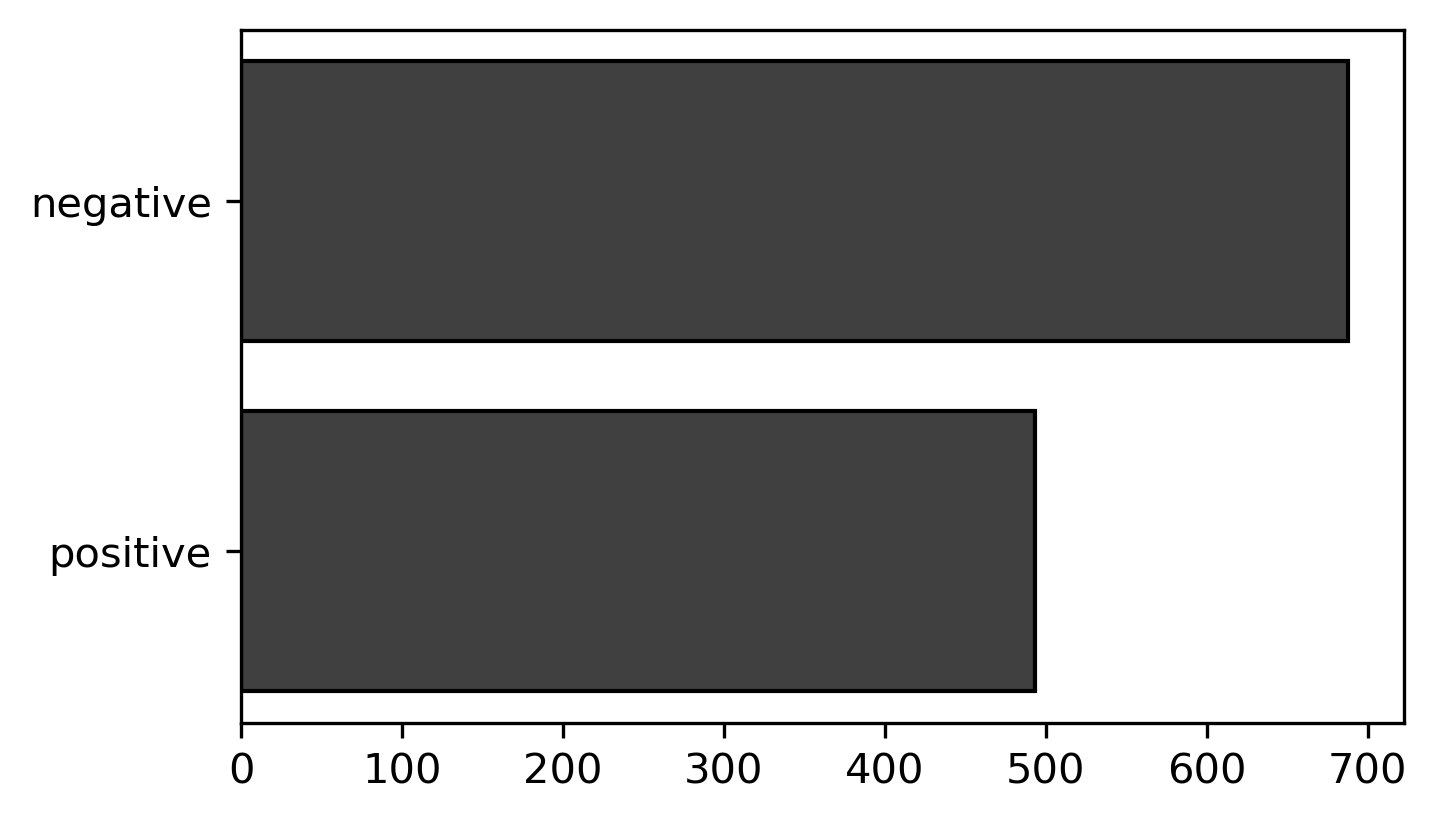

In [328]:
# Print statistics and plot

# For events outside IQR
print("Events outside RF uncertainty:")
events_iqr['sign'] = events_iqr['actual - predicted'].where(events_iqr['actual - predicted'] < 0, 'positive')
events_iqr['sign'] = events_iqr['sign'].where(events_iqr['actual - predicted'] > 0, 'negative')
nums = events_iqr.groupby('sign')['actual - predicted'].count().reset_index()
nums['percent'] = nums['actual - predicted'] / nums['actual - predicted'].sum() * 100
print(nums)
print(f"Total events outside RF uncertainty: {events_iqr.shape[0]}\n")



# For all events
print("All events:")
event['sign'] = event['actual - predicted'].where(event['actual - predicted'] < 0, 'positive')
event['sign'] = event['sign'].where(event['actual - predicted'] > 0, 'negative')
nums = event.groupby('sign')['actual - predicted'].count().reset_index()
nums['percent'] = nums['actual - predicted'] / nums['actual - predicted'].sum() * 100
print(nums)
print(f"Total events: {event.shape[0]}\n")

# Make figure
plt.figure(figsize = (5,3), dpi = 300)
sns.histplot(data = events_iqr, y = 'sign', color = 'black', shrink = 0.8)
plt.xlabel('')
plt.ylabel('')

plt.savefig("figs_raw/FIG2_num_events.svg", format='svg', dpi = 300)

## Categorize sites as waterlogging-prone, stress alleviation prone, and variable by comparing mean anomaly to the random forest uncertainty

In [329]:

# Bin sites into WL, SA, and bimodal based on mean of interpretable anomalies being outside the 2xstd of RF uncertainty

for s in all_data.SITE_ID.unique():
    site_data = all_data[all_data['SITE_ID'] == s]
    site_events = events_iqr[events_iqr['SITE_ID'] == s]
    mean_interpretable_events = site_events['actual - predicted'].mean()
    
    rf_min_thresh = test_thresholds[test_thresholds['SITE_ID'] == s]['p25'].tolist()[0]
    rf_max_thresh = test_thresholds[test_thresholds['SITE_ID'] == s]['p75'].tolist()[0]
    
    if mean_interpretable_events < rf_min_thresh:
        all_data.loc[all_data['SITE_ID'] == s, 'category'] = 'WL'
        events_iqr.loc[events_iqr['SITE_ID'] == s, 'category'] = 'WL'
        
        
    elif mean_interpretable_events > rf_max_thresh:
        all_data.loc[all_data['SITE_ID'] == s, 'category'] = 'SA'
        events_iqr.loc[events_iqr['SITE_ID'] == s, 'category'] = 'SA'
        
    else:
        all_data.loc[all_data['SITE_ID'] == s, 'group'] = 'V'
        events_iqr.loc[events_iqr['SITE_ID'] == s, 'category'] = 'V'
        
all_data = all_data.sort_values(by=['category', 'SITE_ID'])
events_iqr = events_iqr.sort_values(by=['category', 'SITE_ID'])

# Save categories
events_iqr.groupby("SITE_ID")['category'].first().reset_index().to_csv('data_for_figs/fig3_site_categories.csv')

In [330]:
events_iqr.groupby("SITE_ID")['category'].first().reset_index().groupby('category')['SITE_ID'].count()

category
SA    11
V     18
WL    21
Name: SITE_ID, dtype: int64

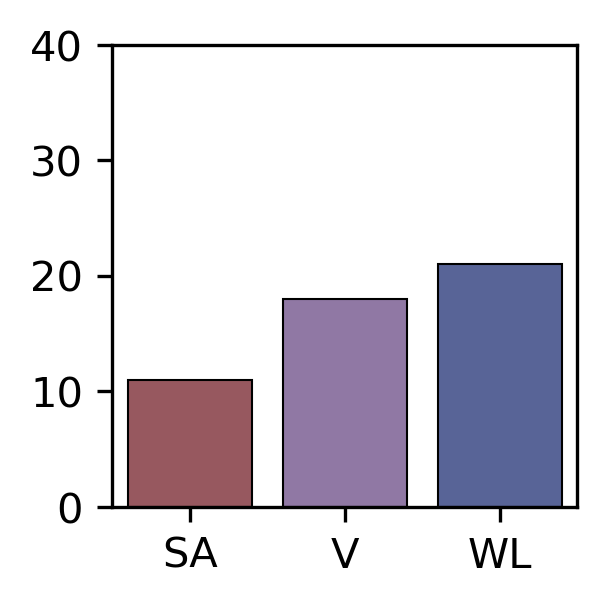

In [332]:
# Make figure

plt.figure(dpi=300, figsize = (2,2))
sns.barplot(data = events_iqr.groupby("SITE_ID")['category'].first().reset_index().groupby('category')['SITE_ID'].count().reset_index(),
             x = 'category', y = 'SITE_ID', hue = 'category', dodge = False, palette = [ks_colors[1], ks_colors[2], ks_colors[0]], linewidth=0.5, edgecolor="black")
plt.xlabel('')
plt.ylabel('')
plt.ylim(0,40)
plt.gca().legend_.remove()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(3))

plt.savefig("figs_raw/FIG3_frac_sites.svg", format='svg', dpi = 300)

plt.show()

In [333]:
def nice_boxplots_exclude_event_overlap(all_data, included_events, test_thresholds, title = '', ms = 3, c = 'black'):
    num_sites = len(all_data.SITE_ID.unique())
    sites = all_data.sort_values(by=['category', 'SITE_ID']).SITE_ID.unique()
    
    mean_line_color = {"WL":'#8b9ad6',
                    "SA":'#cc7882',
                    "V":"#9171AB"}
    anomaly_color = {"WL":ks_colors[0],
                    "SA":ks_colors[1],
                    "V":'#9171AB'}
        
    # Specify y column
    y = 'actual - predicted'
    
    if num_sites > 15:
        fig_height = 12
        num_rows = 4
        if (num_sites-1) % 4 == 0:
            num_columns = int((num_sites-1) / 4) + 1
            extra_box = False
        else:
            num_columns = int((num_sites) / 4) + 1
            extra_box = True
    
    else:
        fig_height = 4
        num_rows = 1
        num_columns = int(num_sites)
        extra_box = False

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(num_columns+2, fig_height))

    # Flatten the axs array for easier iteration
    axs = axs.flatten()

    # Loop through columns and rows to create plots
    for col in range(num_columns * num_rows):
        try: df_subset = all_data[all_data['SITE_ID'] == sites[col]]
        except IndexError:
            axs[col].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
            axs[col].yaxis.set_tick_params(left=False) # to remove the tick marks
            axs[col].set_ylabel('')
            break
        
        # For the site, get the event and test data
        df_test = df_subset[df_subset['DATA'] == 'test']
        df_event = df_subset[df_subset['DATA'] == 'event']
        
        
        # get the included and excluded events
        df_event_included = included_events[included_events['SITE_ID'] == sites[col]]
        
        # Get the site category
        category = set(df_event_included['category']).pop()
        
        df_excluded = pd.merge(df_event,df_event_included, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
        #print(sites[col], df_excluded.shape[0], df_event_included.shape[0])
        
        # plot the mean of the excluded events
        df_mean = df_event_included['actual - predicted'].mean()
        axs[col].axhline(y = df_mean, color = mean_line_color[category],  lw = 2.5, zorder = 90)
    
        
        # Plot excluded events in black and the included in color
        sns.swarmplot(data=df_excluded, y=y, ax=axs[col], color='black', alpha = 1, edgecolor = 'black', size = 2, dodge = False, zorder = 2)
        sns.swarmplot(data=df_event_included, y=y, ax=axs[col], color=anomaly_color[category], edgecolor = 'black', size = 3, linewidth = 0.25, dodge = False, zorder = 102, alpha = 1)
        x_bot, x_top = axs[col].get_xlim()

        # Add mean and 2xSTD to RF uncertainty
        test_thresh_site = test_thresholds[test_thresholds['SITE_ID'] == sites[col]].reset_index().iloc[0]
        #axs[col].axhline(y=test_thresh_site.loc["site_mean"], c = 'black', lw = 1, zorder = 4)
        axs[col].fill_between(x = [x_bot, x_top], y1 = test_thresh_site.loc["p25"], y2 = test_thresh_site.loc["p75"], color = '#C6CA53', zorder = 0, alpha = 0.7)
        


        axs[col].set_ylabel('Actual - Predicted GPP\n' + r"[$gC m^{-2} d^{-1}$]")
        if not col in [0,num_columns, num_columns *2, num_columns * 3]:
            axs[col].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
            axs[col].yaxis.set_tick_params(left=False) # to remove the tick marks
            axs[col].set_ylabel('')
        #axs[col].yaxis.grid(True, alpha = 0.5, color = 'gray')
        axs[col].set_ylim(-10,10)
        axs[col].set_xlim(x_bot, x_top)

        axs[col].set_title(sites[col])
        axs[col].get_xaxis().set_visible(False)
    
    
    if extra_box == True:
       
        last_col = num_sites - 1
        axs[last_col].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
        axs[last_col].yaxis.set_tick_params(left=False) # to remove the tick marks
        axs[last_col].set_ylabel('')
        axs[last_col].get_xaxis().set_visible(False)
    
    fig.suptitle(title)
    
    return fig
    
    


For WL sites that look bimodal:
(SITE_ID: #events, %negevents, #negevents)
AU-Stp: 43, 0.6046511627906976, 26
AU-TTE: 30, 0.7, 21
US-Var: 132, 0.5606060606060606, 74
US-Whs: 51, 0.6666666666666666, 34




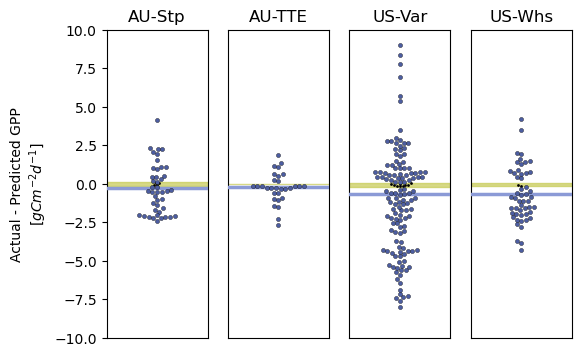

In [334]:
sites_on_the_fence = ['AU-Stp', 'AU-TTE', 'US-Var', 'US-Whs']
all_data_plot = all_data[all_data['SITE_ID'].isin(sites_on_the_fence)] # no anomalies outside RF uncertainty
events_plot = events_iqr[events_iqr['SITE_ID'].isin(sites_on_the_fence)] # no anomalies outside RF uncertainty

print("For WL sites that look bimodal:\n(SITE_ID: #events, %negevents, #negevents)")
for i in sites_on_the_fence:
    temp = events_plot[events_plot['SITE_ID'] == i]
    gt_rf_unc = temp[temp['actual - predicted'] > temp['p75']].shape[0]
    lt_rf_unc = temp[temp['actual - predicted'] < temp['p25']].shape[0]
    print(f"{i}: {gt_rf_unc + lt_rf_unc}, {lt_rf_unc / (gt_rf_unc + lt_rf_unc)}, {lt_rf_unc}")
print('\n')

nice_boxplots_exclude_event_overlap(all_data_plot, events_plot, test_thresholds, title = '', ms = 2.5, c = 'blue')

#### AS A TEST: RECLASSIFY THESE SITES AS BIMODAL

all_data.loc[all_data['SITE_ID'] == 'AU-Stp', 'category'] = 'V'
all_data.loc[all_data['SITE_ID'] == 'AU-TTE', 'category'] = 'V'
all_data.loc[all_data['SITE_ID'] == 'US-Var', 'category'] = 'V'
all_data.loc[all_data['SITE_ID'] == 'US-Whs', 'category'] = 'V'
events_iqr.loc[events_iqr['SITE_ID'] == 'AU-Stp', 'category'] = 'V'
events_iqr.loc[events_iqr['SITE_ID'] == 'AU-TTE', 'category'] = 'V'
events_iqr.loc[events_iqr['SITE_ID'] == 'US-Var', 'category'] = 'V'
events_iqr.loc[events_iqr['SITE_ID'] == 'US-Whs', 'category'] = 'V'



/Users/ericamcc/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ericamcc/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ericamcc/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ericamcc/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erica

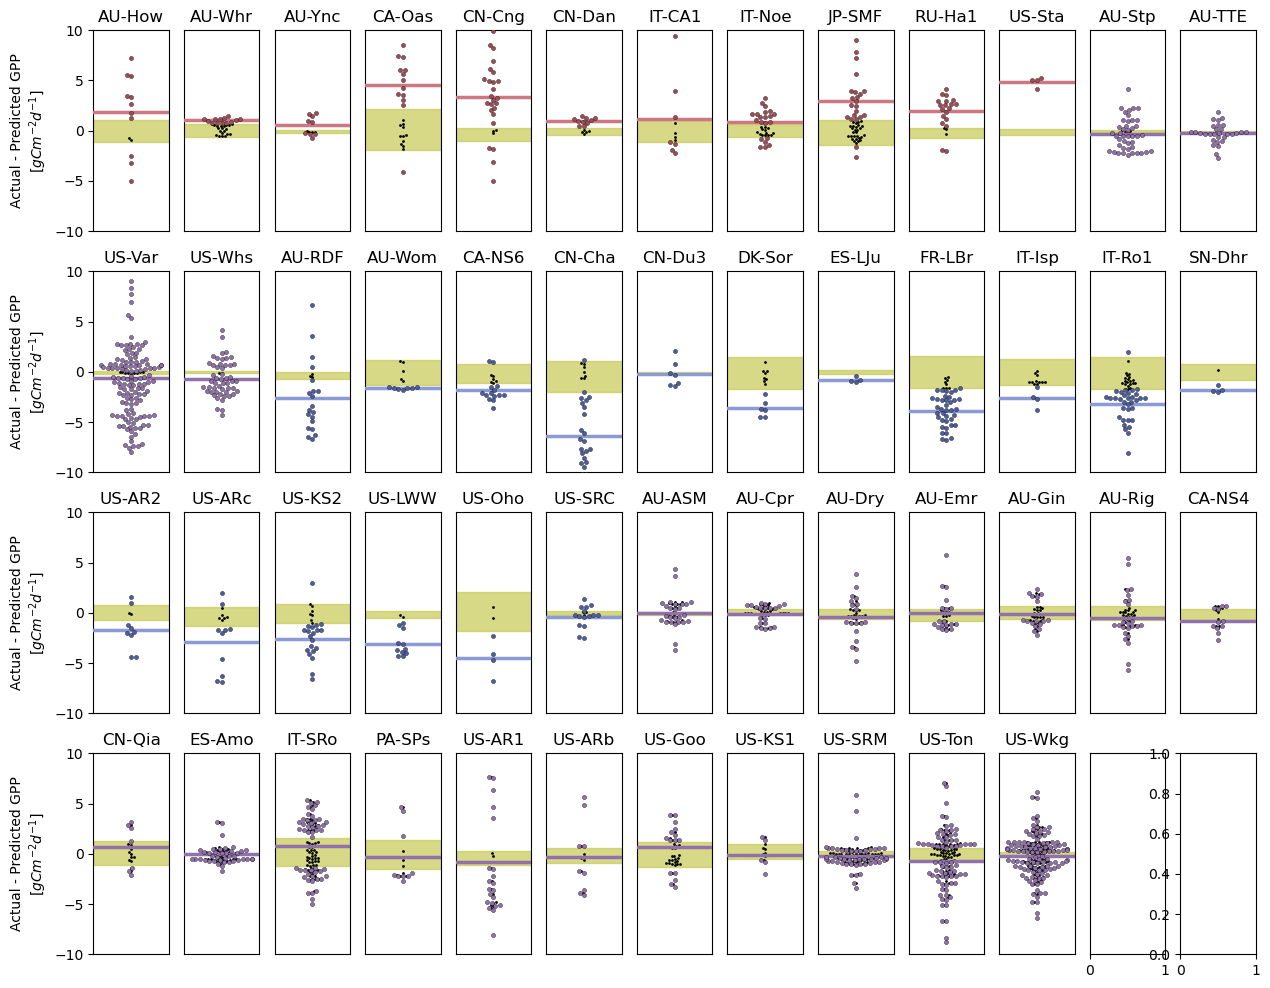

In [272]:
fig = nice_boxplots_exclude_event_overlap(all_data, events_iqr, test_thresholds, title = '', ms = 2.5, c = 'blue')
fig.savefig("figs_raw/SI_all_site_categories.svg", format='svg', dpi = 300)

US-KS2 7 20
RU-Ha1 3 19
AU-Stp 4 43


/var/folders/gv/q1vvdfwj7738_4zfvm4pzlz40000gp/T/ipykernel_5706/900334765.py:80: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


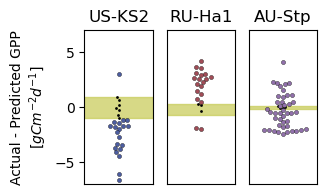

In [273]:
def nice_boxplots_poster(all_data, included_events, test_thresholds, title = '', ms = 3, c = 'black'):

    anomaly_color = {"WL":ks_colors[0],
                    "SA":ks_colors[1],
                    "V":'#9171AB'}
    sites = all_data.sort_values(by='SITE_ID').SITE_ID.unique()
    
    # Specify y column
    y = 'actual - predicted'
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize = (3,2))

    # Flatten the axs array for easier iteration
    axs = axs.flatten()


    # Loop through columns and rows to create plots
    for col in range(3):
        
        
        df_subset = all_data[all_data['SITE_ID'] == sites[col]]
        
         # For the site, get the event and test data
        df_test = df_subset[df_subset['DATA'] == 'test']
        df_event = df_subset[df_subset['DATA'] == 'event']
        
        
        # get the included and excluded events
        df_event_included = included_events[included_events['SITE_ID'] == sites[col]]
        
        # Get the site category
        category = set(df_event_included['category']).pop()
        
        df_excluded = pd.merge(df_event,df_event_included, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
        print(sites[col], df_excluded.shape[0], df_event_included.shape[0])
        
        # plot the mean of the excluded events
        #df_mean = df_event_included['actual - predicted'].mean()
        #axs[col].axhline(y = df_mean, color = mean_line_color[category],  lw = 2.5, zorder = 90)
    
        
        # Plot excluded events in black and the included in color
        sns.swarmplot(data=df_excluded, y=y, ax=axs[col], color='black', alpha = 1, edgecolor = 'black', size = 2, dodge = False, zorder = 2)
        sns.swarmplot(data=df_event_included, y=y, ax=axs[col], color=anomaly_color[category], edgecolor = 'black', size = 3, linewidth = 0.25, dodge = False, zorder = 102, alpha = 1)
        x_bot, x_top = axs[col].get_xlim()

        # Add mean and 2xSTD to RF uncertainty
        test_thresh_site = test_thresholds[test_thresholds['SITE_ID'] == sites[col]].reset_index().iloc[0]
        #axs[col].axhline(y=test_thresh_site.loc["site_mean"], c = 'black', lw = 1, zorder = 4)
        axs[col].fill_between(x = [x_bot, x_top], y1 = test_thresh_site.loc["p25"], y2 = test_thresh_site.loc["p75"], color = '#C6CA53', zorder = 0, alpha = 0.7)
        

        axs[col].set_ylabel('Actual - Predicted GPP\n' + r"[$gC m^{-2} d^{-1}$]")
        if not col in [0]:
            axs[col].yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
            axs[col].yaxis.set_tick_params(left=False) # to remove the tick marks
            axs[col].set_ylabel('')
        #axs[col].yaxis.grid(True, alpha = 0.5, color = 'gray')
        axs[col].set_ylim(-7,7)
        axs[col].set_xlim(x_bot, x_top)

        axs[col].set_title(sites[col])
        axs[col].get_xaxis().set_visible(False)
    
    
    fig.suptitle(title)
    return fig
    
    


sites = ['US-KS2', 'RU-Ha1', 'AU-Stp']
example_sites = all_data[all_data['SITE_ID'].isin(sites)] 
example_sites['SITE_ID'] = example_sites['SITE_ID'].astype("category")
example_sites['SITE_ID'] = example_sites['SITE_ID'].cat.set_categories(sites)


fig = nice_boxplots_poster(example_sites, events_iqr, test_thresholds, title = '', ms = 2.5, c = 'blue')
fig.show()
fig.savefig('figs_raw/FIG3_example.svg', format='svg', dpi = 300)

### Print sites for table

In [348]:
events_iqr.groupby('SITE_ID').count()[['day']].to_csv('final_num_event_days_for_table.csv')

In [342]:
events_iqr.drop_duplicates(subset='SITE_ID')[['SITE_ID', 'LOCATION_LAT', 'LOCATION_LONG', 'category', 'R2', 'num_event_days', 'DOI', 'REFERENCE_PAPER']].to_csv('fluxnet_sites_for_table.csv')

### Compare storm durations across groups

Number of events associated with storms <= 3 days: 607
Number of total evetn days: 1181
Fraction of event days associated with storms <=3 days: 0.5139712108382727

Number of storms: 437
Number of storms <= 3 days: 256
Number of storms: 437
Fraction of storms <=3 days: 0.585812356979405


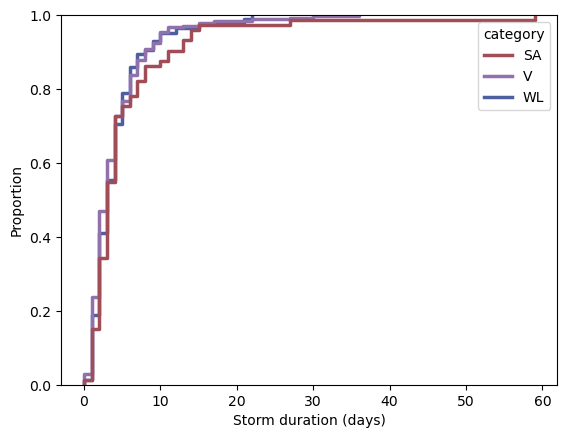

In [274]:
storm_df = events_iqr.drop_duplicates(subset = ['SITE_ID', 'storm_start', 'storm_end', 'storm_length'])

num_events_lt_1week = events_iqr[events_iqr['storm_length'] <= 3].shape[0]
num_events_total = events_iqr.shape[0]
print(f"Number of events associated with storms <= 3 days: {num_events_lt_1week}\nNumber of total evetn days: {num_events_total}\nFraction of event days associated with storms <=3 days: {num_events_lt_1week / num_events_total}")

print(f"\nNumber of storms: {storm_df.shape[0]}")
num_events_lt_1week = storm_df[storm_df['storm_length'] <= 3].shape[0]
num_events_total = storm_df.shape[0]
print(f"Number of storms <= 3 days: {num_events_lt_1week}\nNumber of storms: {num_events_total}\nFraction of storms <=3 days: {num_events_lt_1week / num_events_total}")

sns.ecdfplot(data = storm_df.sort_values(by='category', ascending = True), x = 'storm_length', hue = 'category', palette = [ks_colors[1], ks_colors[2], ks_colors[0]], lw = 2.5)
plt.xlabel('Storm duration (days)')
plt.savefig('figs_raw/SI_stormdistribution.svg', format = 'svg', dpi = 300)

# KS groups are mean of events, compare to event IQR to make thresholds

In [275]:
# Dictionaries to parse koppen and IGBP types

meta['koppen_letter'] = [str(i)[0] for i in meta['koppen'].values]
koppen_main_groups = {"A":"Tropical",
                      "B":"Arid",
                      "C":"Temperate",
                      "D":"Continental",
                      "E":"Polar",
                      "n":np.nan}

koppen_sort_dict = {"A":0,
                      "B":1,
                      "C":2,
                      "D":3,
                      "E":4,
                      "n":np.nan}



igbp_groups = {
               "DBF":"Forest",
               "DNF":"Forest",
               "EBF":"Forest",
               "ENF":"Forest",
               "MF":"Forest",
               "CSH":"Closed shrubland",
               "OSH":"Open shrubland",
               "SAV":"Savannas",
               "WSA":"Woody savannas",
               "GRA":"Grasslands",}


woody_groups = {
                "DBF":"Woody",
                "DNF":"Woody",
                "EBF":"Woody",
                "ENF":"Woody",
                "MF":"Woody",
                "CSH":"Woody",
                "OSH":"Non-woody",
                "SAV":"Non-woody",
                "WSA":"Woody",
                "GRA":"Non-woody",
}

igbp_sort_dict = {
               "DBF":0,
               "DNF":1,
               "EBF":2,
               "ENF":3,
               "MF":4,
               "CSH":5,
               "OSH":6,
               "SAV":7,
               "WSA":8,
               "GRA":9,}



# Replace IGBP with koppen and landcover types in metadata
meta['igbp_name'] = meta['IGBP'].replace(igbp_groups)
meta['woody_groups'] = meta['IGBP'].replace(woody_groups)
meta['koppen_letter_simple'] = meta['koppen_letter'].replace(koppen_main_groups)



In [276]:
# Set the category as a category and assign order
events_iqr['category'] = events_iqr['category'].astype("category")
events_iqr['category'] = events_iqr['category'].cat.set_categories(["WL", "SA", "V"], ordered = True)


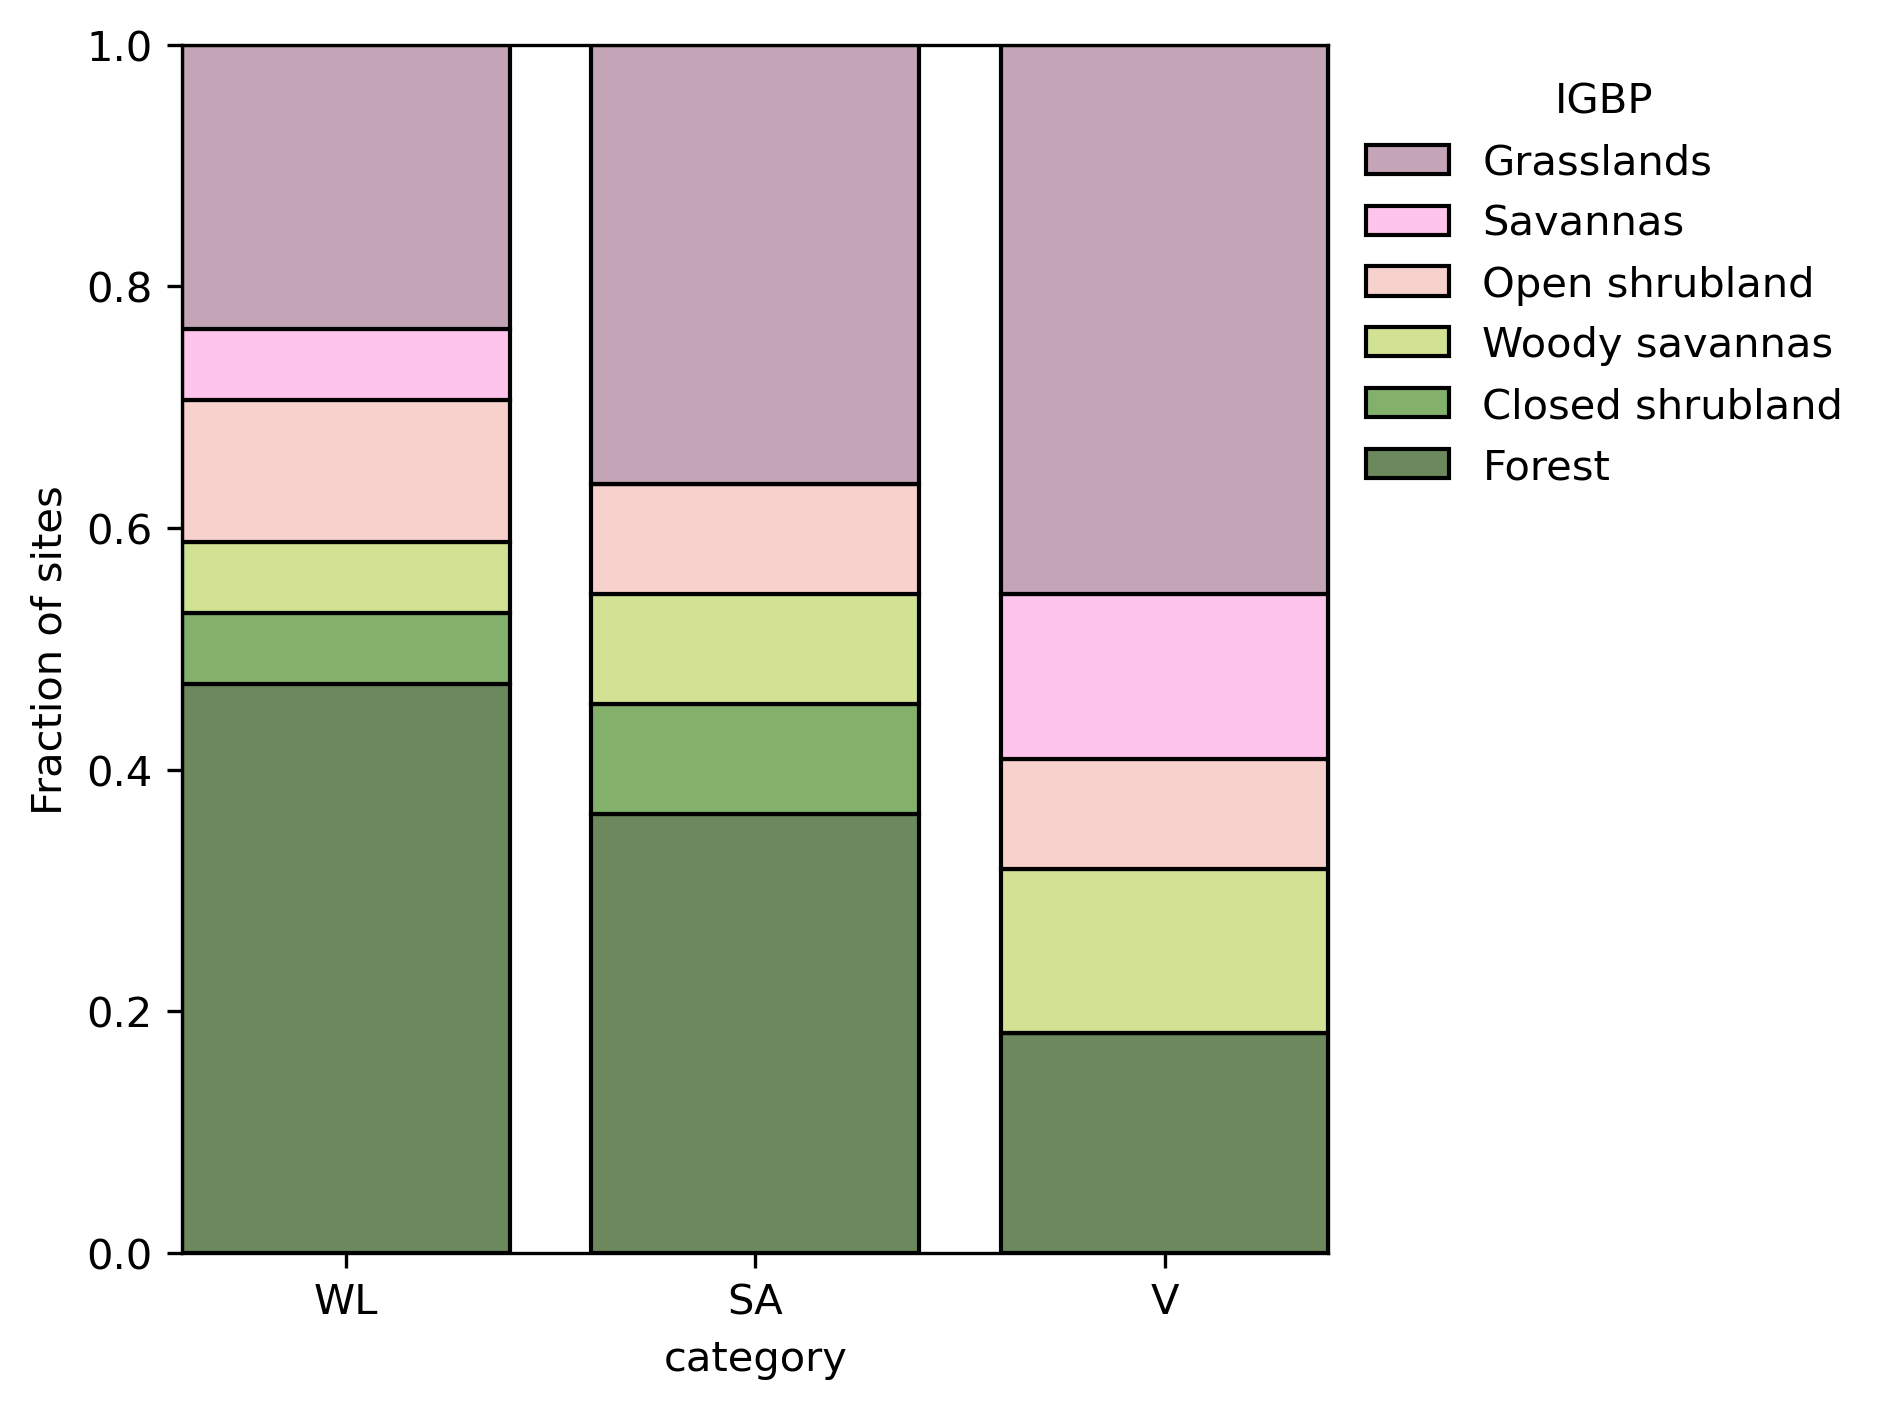

In [277]:
bar_palette = {'Grasslands':'#B0869F',
               'Savannas':'#FFB1E6',
               'Open shrubland':'#F5C2BC',
                'Woody savannas':'#C2D971',
               'Closed shrubland':'#5A9639',
               'Forest':'#3A6125'}

df = events_iqr[['SITE_ID', 'category']].merge(meta, how = 'left', on = 'SITE_ID')
plt.figure(dpi=300)
y = 'actual - predicted'
df = df.drop_duplicates(subset = "SITE_ID")
df['igbp_name'] = pd.Categorical(df['igbp_name'], ['Grasslands', 'Savannas',  'Open shrubland', 'Woody savannas', 'Closed shrubland', 'Forest'])
ax = sns.histplot(data = df, x = "category", hue = "igbp_name", stat = 'percent', multiple="fill", common_norm = True, shrink=.8, legend = True,palette = bar_palette)#, element="step", fill=False)
plt.ylabel("Fraction of sites")           
leg =ax.get_legend().set_title('IGBP')


sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1), frameon = False)
plt.tight_layout()
plt.savefig("figs_raw/FIG4_landcoverpercent.svg", format='svg')


In [278]:
woody_groups = {
    "Woody savannas":"Woody",
    "Closed shrubland":"Woody",
    "Forest":"Woody",
    "Grasslands":"Not",
    "Savannas":"Not",
    "Open shrubland":"Not"
}

df['woody'] = df['igbp_name'].replace(woody_groups)
for i in ['WL', 'SA', 'V']:
    temp = df[df['category'] == i]
    print(temp[temp['woody'] == 'Woody'].shape[0] / temp.shape[0])


0.5882352941176471
0.5454545454545454
0.3181818181818182


In [279]:
events_iqr.groupby('category')['SITE_ID'].count()

category
WL    230
SA    154
V     783
Name: SITE_ID, dtype: int64

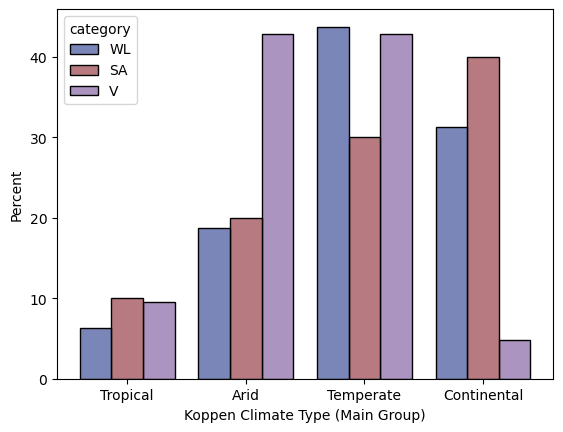

<Figure size 640x480 with 0 Axes>

In [280]:

df = df.sort_values(by=['koppen_letter'], key=lambda x: x.map(koppen_sort_dict))
sns.histplot(data = df, x = "koppen_letter_simple", hue = "category", stat = 'percent', multiple="dodge", shrink=.8, common_norm = False,  palette = ks_colors[0:3], legend = True)#, element="step", fill=False)
plt.xlabel("Koppen Climate Type (Main Group)")
plt.ylabel("Percent")
plt.show()
plt.savefig('figs_raw/SI_koppen.svg', format='svg')

In [281]:
# Dictionaries for label names and min and max axes values

ylabels = {'hnd': "HAND (m)",
    'elv': "Elevation (m)",
    'swc_99_min_90': "Likelihood of high SWC\n(SWC\u2089\u2089 - SWC\u2089\u2080) (mm)",
    'bdod_mean_alldepth' : "Bulk density (g/kg)",
    'ksat_surface': "log Ksat (mm/s)",
    'sand': "Sand (%)",
    'clay': "Clay (%)",
    'event_over_test_days': 'Percentage of high-quality data\nclassified as pluvial event (%)',
    'swc_99': "SWC at the 99th\ndaily percentile [m3/m3]",
    'storm_amount_pluvial_event_mean': 'Mean storm amount (mm)',
    'storm_length_pluvial_event_mean': 'Mean storm length (days)',
    'soil_skew': "SWC distribution skew",
    'aridity_new': "PET/P (annual)",
    'PET': "PET (mm)",
    'MAP_y':"MAP (mm)",
    "koppen_category":"Koppen Group",
    "porosity":"Soil porosity (%)",
    'twi':"TWI",
    "MAT_y":"MAT (C)",
    'WTD':"Water table depth (m)",
    'mean_lai':"Mean LAI (-)",
    'num_event_days':"Number of extreme event days",
    "R2":"RF model performance (R2)"}

min_val = 0
y_lim_min = {'hnd': min_val,
              'swc_99_min_90': min_val,
              'elv': min_val,
              'ksat_surface': 0.175,
              'sand': min_val,
              'clay': min_val,
              'silt': min_val,
              'event_over_test_days': min_val,
              'swc_99': min_val,
              'mean_gpp': min_val,
              'storm_amount_pluvial_event_mean': min_val,
              'storm_length_pluvial_event_mean': min_val,
              'soil_skew': -2,
              'bdod_mean_alldepth': 1,
              'aridity_fall': min_val,
              'aridity_spring': min_val,
              'aridity_summer': min_val, 
              'aridity_winter': min_val,
              'aridity_new': -1,
              'PET': min_val,
              'MAP_y': min_val,
              'porosity':35,
              'twi':-4,
              'MAT_y':-5,
              'WTD':-150,
              'mean_lai':0}

1


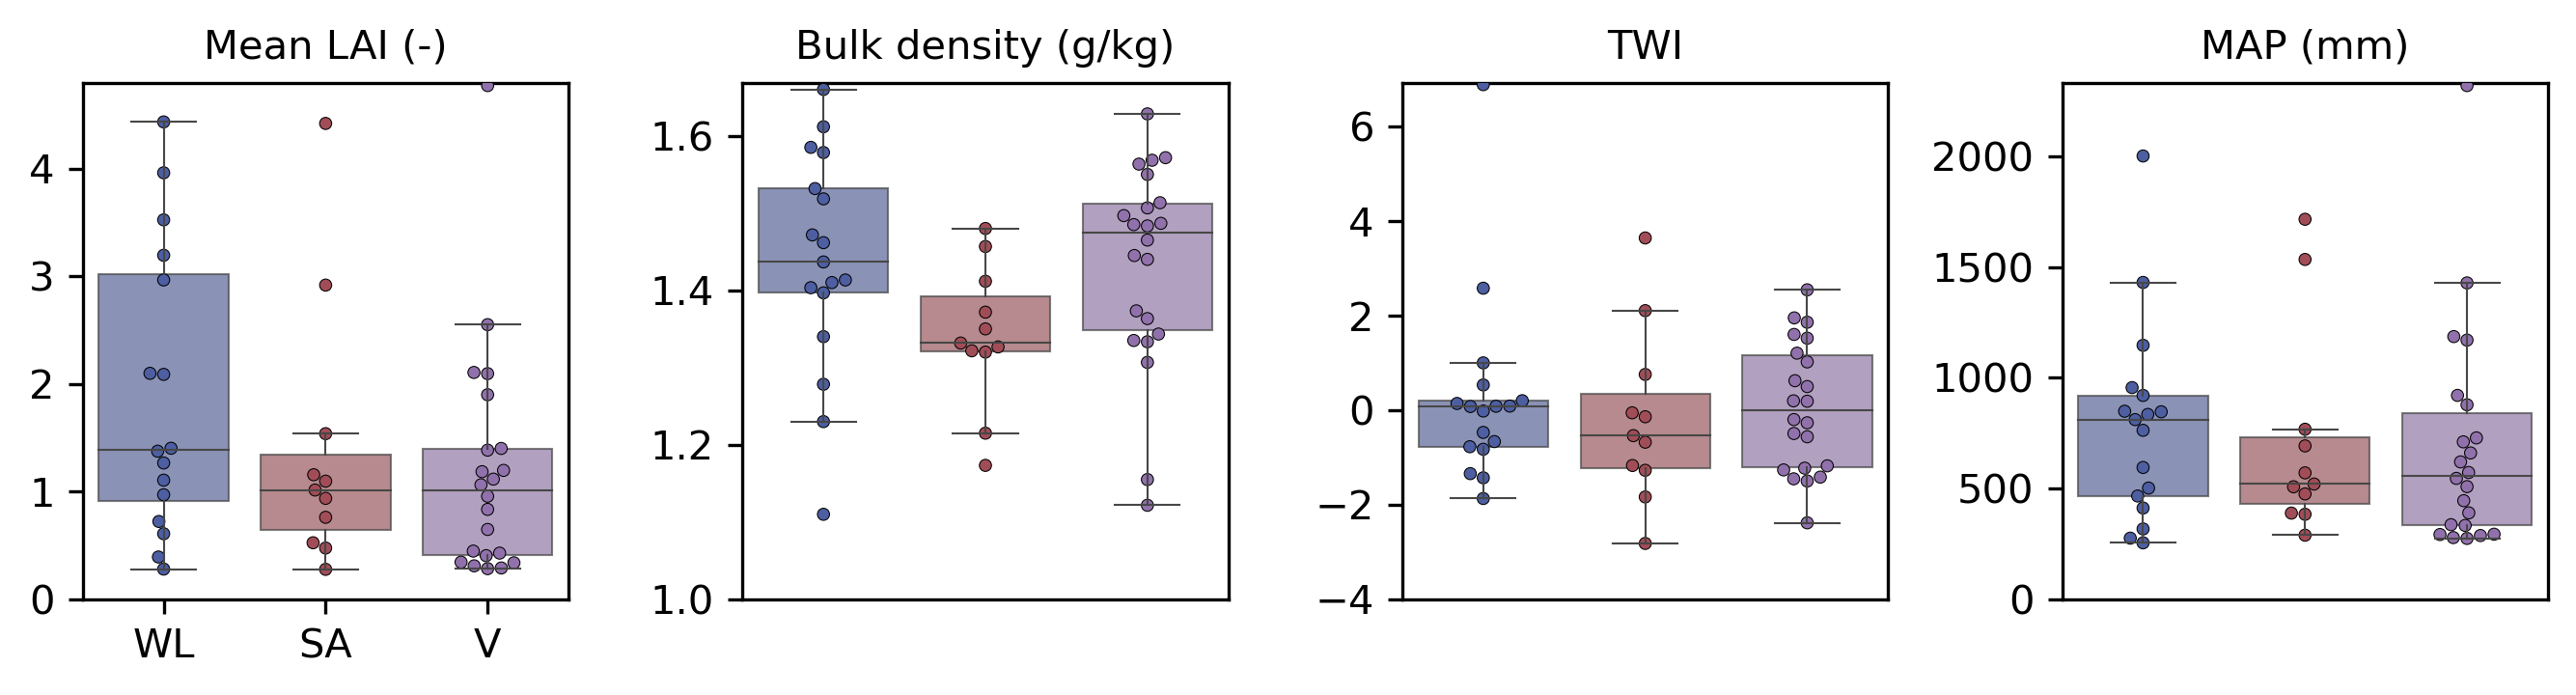

3


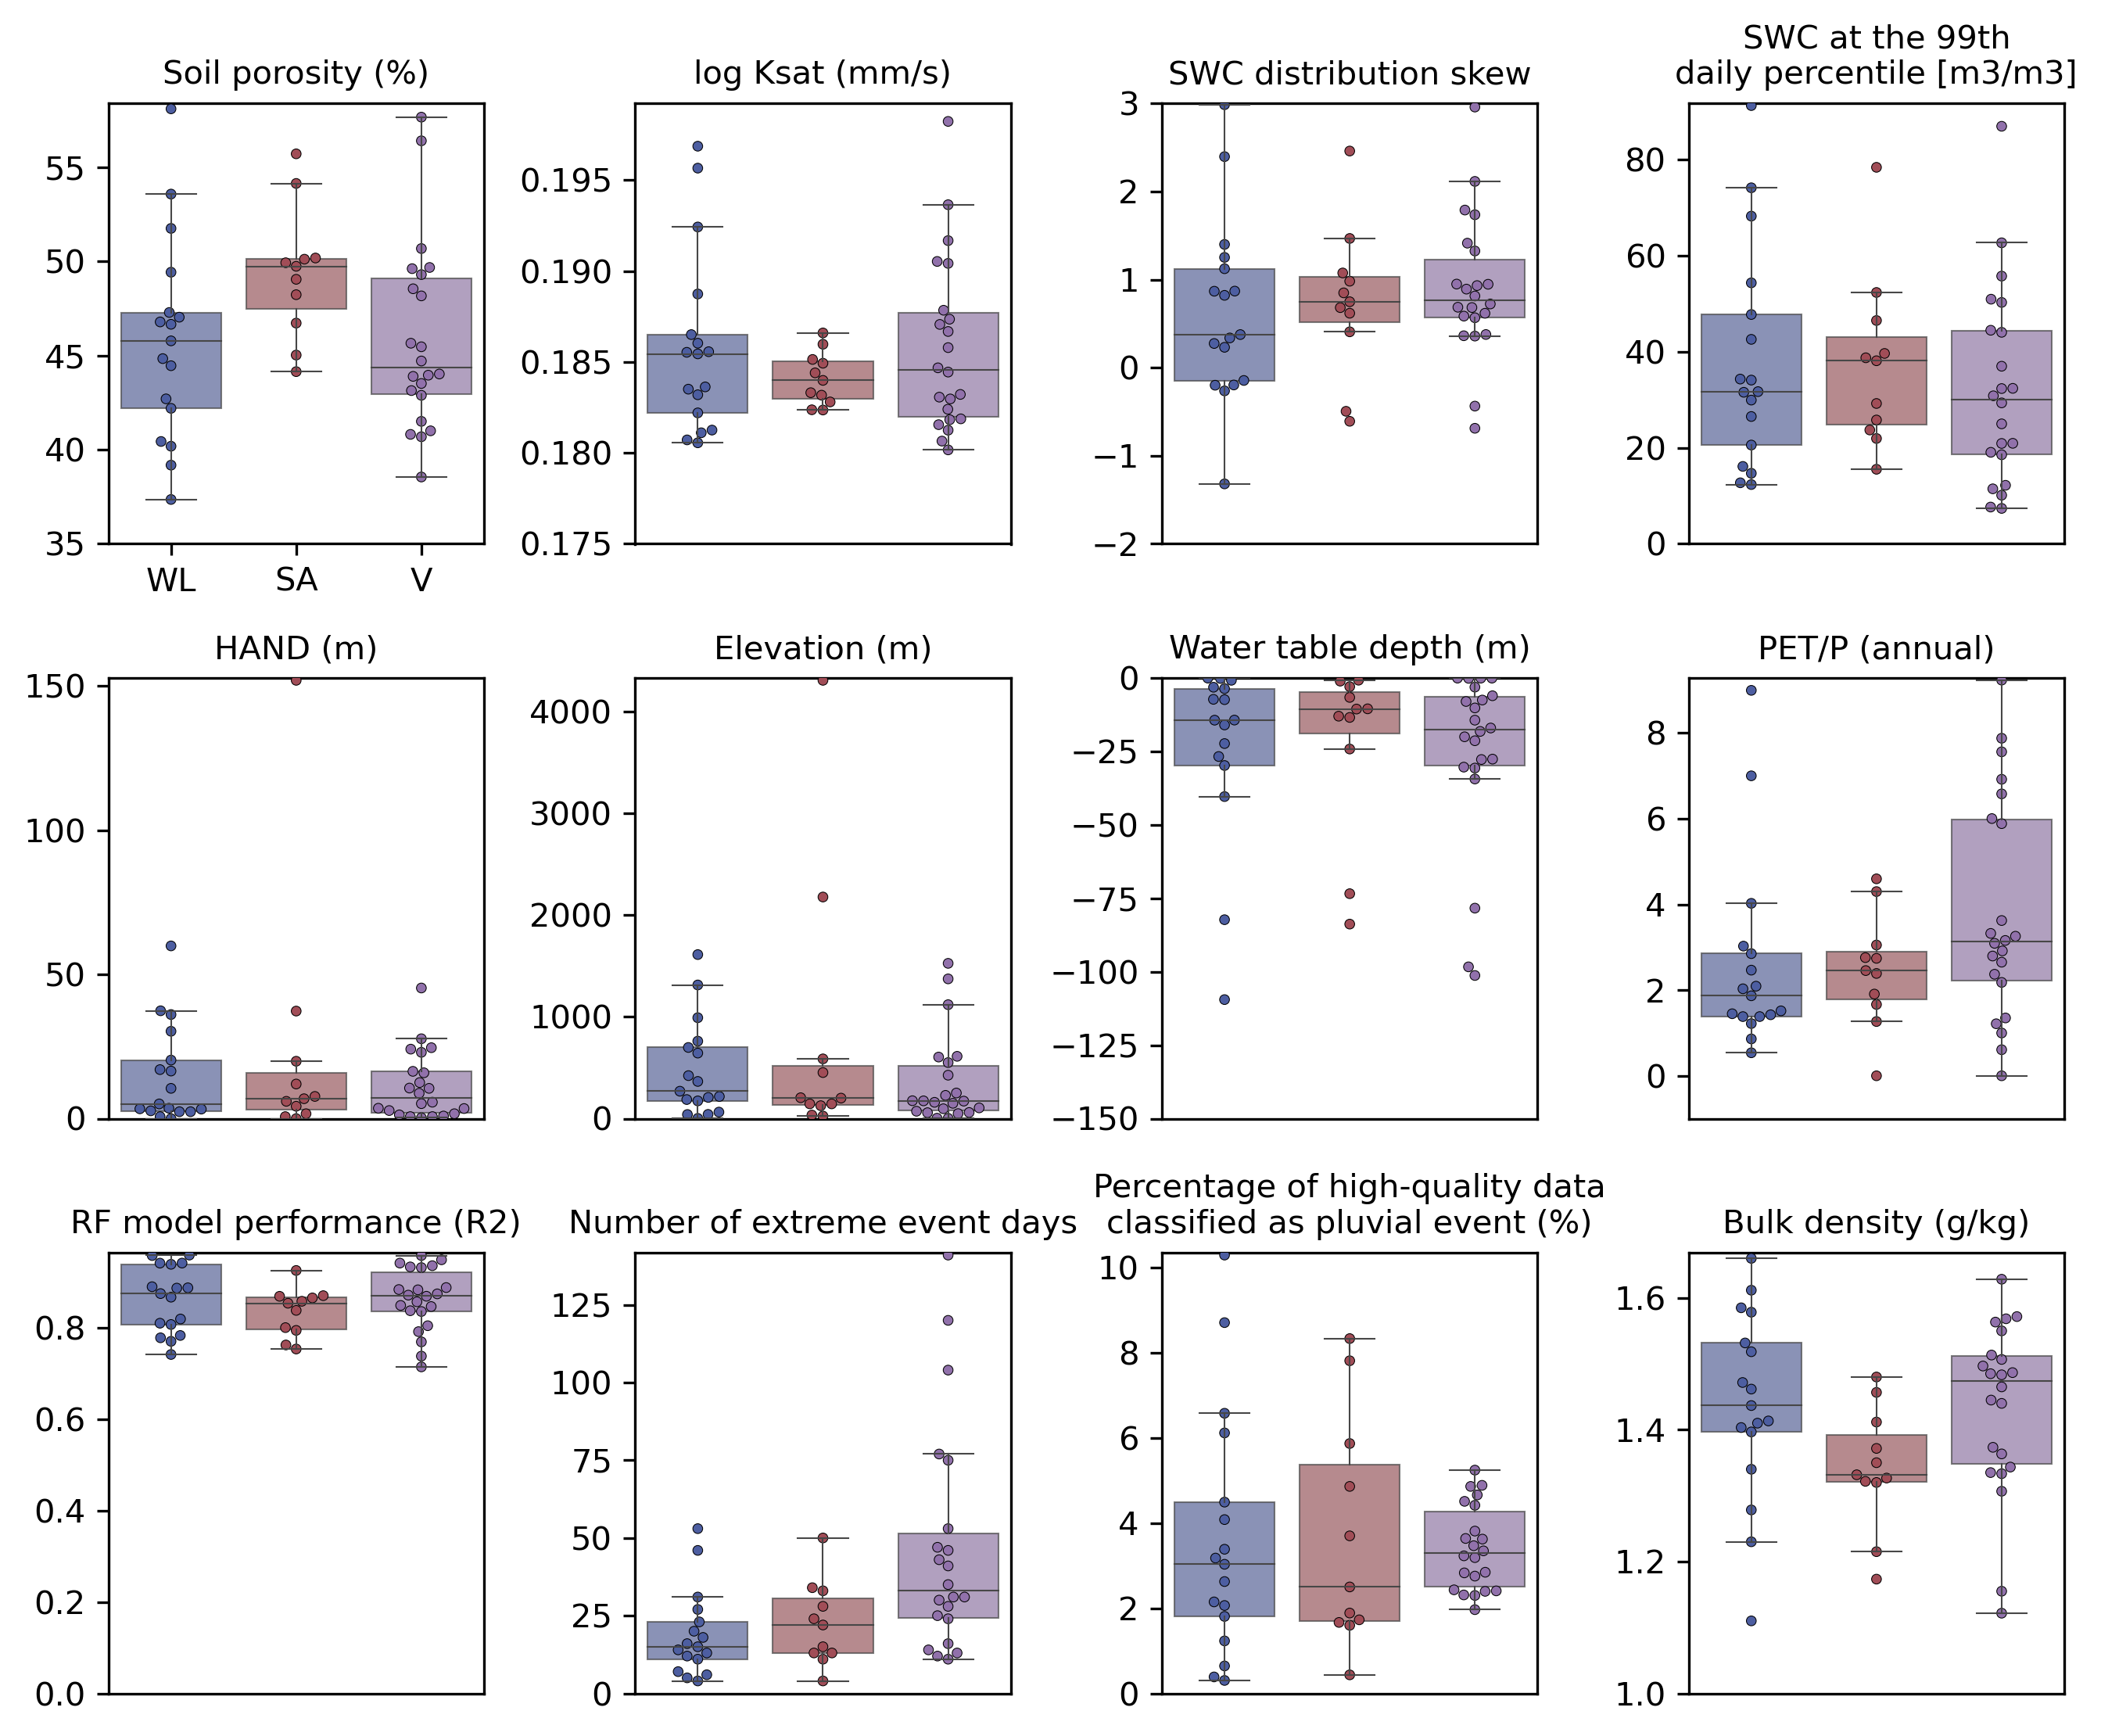

In [282]:
def nice_factor_boxplots(df, meta, factors, ylabels):

    num_cols = int(len(factors) / 4)
    print(num_cols)
    # Create subplots
    fig, axs = plt.subplots(num_cols, 4, figsize = (9,2.5*num_cols), dpi = 300)

    # Flatten the axs array for easier iteration
    axs = axs.flatten()

    # Loop through columns and rows to create plots
    for col in range(len(factors)):

        sns.boxplot(data=df,  x = 'category', y=factors[col], ax=axs[col],  palette = ks_colors, fliersize = 0, linewidth = 0.5, zorder = 3015, boxprops=dict(alpha=.7), )
        sns.swarmplot(data=df, x = 'category', y=factors[col], ax=axs[col], palette = ks_colors, alpha = 1,  edgecolor = 'black', size = 3, linewidth = 0.25, zorder = 16, legend = True ) #facecolor = 'white',

        try:
            min_y = y_lim_min[factors[col]]
        except KeyError:
            min_y = 0
       
        max_y = df[factors[col]].max() + ((df[factors[col]].max() * 0.005))
        axs[col].set_ylim(min_y, max_y)
        try:
            axs[col].set_title(ylabels[factors[col]],  fontsize=10)#, labelpad=0.5)
        except:
            axs[col].set_title(factors[col],  fontsize=10)
        axs[col].set_ylabel('')#, labelpad=0.5)

        axs[col].legend([],[], frameon=False)
        
        if col ==0:
            axs[col].tick_params(axis='x', which='both', labelsize=10)#
            axs[col].set_xlabel('',  fontsize=15)#, labelpad=0.5)
        else:
            axs[col].get_xaxis().set_visible(False)

    #plt.subplots_adjust(wspace=0.2, hspace=0.6)
    plt.tight_layout()
    plt.show()
    return fig

fig1 = nice_factor_boxplots(events_iqr.drop_duplicates(subset = 'SITE_ID'), meta,
                            factors = ['mean_lai', 'bdod_mean_alldepth', 'twi', 'MAP_y'],
                            ylabels = ylabels)
fig2 = nice_factor_boxplots(events_iqr.drop_duplicates(subset = 'SITE_ID'), meta,
                            factors = ['porosity', 'ksat_surface', 'soil_skew', 'swc_99',
                                       'hnd', 'elv', 'WTD', 'aridity_new',
                                       'R2','num_event_days', 'event_over_test_days', 'bdod_mean_alldepth'],
                            ylabels = ylabels)


fig1.savefig("figs_raw/FIG4_boxplots.svg", format='svg')
fig2.savefig("figs_raw/SI_boxplots.svg", format='svg')


In [235]:
# Print statistical significant differences 

def calculate_sig_characteristics(df, cat1, cat2, cols_to_compare, sig_thresh = 0.05):
    pvals = []
    group = []
    xx = []
    for x in cols_to_compare:
        sample_waterlogging = np.array(df[df['category'] == cat1][x])
        sample_alleviation = np.array(df[df['category'] == cat2][x])
        if sample_waterlogging.shape[0] > 0:
            xx.append(x)
            stat, pval = stats.ttest_ind(sample_waterlogging, sample_alleviation, equal_var = False)
            if pval < sig_thresh:
                group.append(f"{cat1} and {cat2} different")
            else:    
                group.append('same')
            pvals.append(pval)
    results = pd.DataFrame({"X":xx, "pval":pvals, "group":group})
    results = results.sort_values(by = 'group')
    print(results[results['group'] != 'same'], '\n\n')
    print(results[results['group'] == 'same'], '\n\n')


cols_to_compare = ['porosity', 'MAP_y', 'twi', 'mean_lai',
                    'bdod_mean_alldepth', 'ksat_surface', 'soil_skew', 'swc_99',
                    'hnd', 'elv', 'WTD', 'aridity_new',
                    'R2','num_event_days', 'event_over_test_days', 'TA_F',
                    '']

calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID'), 'WL', 'SA', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)
calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID'), 'WL', 'V', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)
calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID'), 'SA', 'V', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)
calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID'), 'SA', 'WL', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)
calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID'), 'V', 'SA', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)

                    X      pval                group
0            porosity  0.040219  WL and SA different
4  bdod_mean_alldepth  0.040219  WL and SA different 


                       X      pval group
1                  MAP_y  0.684205  same
2                    twi  0.563067  same
3               mean_lai       NaN  same
5           ksat_surface  0.195288  same
6              soil_skew  0.764616  same
7                 swc_99  0.943689  same
8                    hnd  0.587346  same
9                    elv  0.494669  same
10                   WTD  0.356478  same
11           aridity_new  0.848519  same
12                    R2  0.269276  same
13        num_event_days  0.499171  same
14  event_over_test_days  0.941832  same
15                  TA_F  0.927624  same 


                 X     pval               group
13  num_event_days  0.00285  WL and V different 


                       X      pval group
0               porosity  0.928176  same
1                  MAP_y  0.523450  sam

In [236]:
cols_to_compare

['porosity',
 'MAP_y',
 'twi',
 'mean_lai',
 'bdod_mean_alldepth',
 'ksat_surface',
 'soil_skew',
 'swc_99',
 'hnd',
 'elv',
 'WTD',
 'aridity_new',
 'R2',
 'num_event_days',
 'event_over_test_days',
 'TA_F']

In [252]:
calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID'), 'WL', 'SA', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)


                    X      pval                group
0            porosity  0.040219  WL and SA different
4  bdod_mean_alldepth  0.040219  WL and SA different 


                       X      pval group
1                  MAP_y  0.684205  same
2                    twi  0.563067  same
3               mean_lai       NaN  same
5           ksat_surface  0.195288  same
6              soil_skew  0.764616  same
7                 swc_99  0.943689  same
8                    hnd  0.587346  same
9                    elv  0.494669  same
10                   WTD  0.356478  same
11           aridity_new  0.848519  same
12                    R2  0.269276  same
13        num_event_days  0.499171  same
14  event_over_test_days  0.941832  same
15                  TA_F  0.927624  same 




In [237]:
landcover_t_test[['SITE_ID', 'category', 'woody_groups', 'IGBP']]

,SITE_ID,category,woody_groups,IGBP
0,AU-How,SA,Woody,WSA
1,AU-Whr,SA,Woody,EBF
2,AU-Ync,SA,Non-woody,GRA
3,CA-Oas,SA,Woody,DBF
4,CN-Cng,SA,Non-woody,GRA
5,CN-Dan,SA,Non-woody,GRA
6,IT-CA1,SA,Woody,DBF
7,IT-Noe,SA,Woody,CSH
8,JP-SMF,SA,Woody,MF
9,RU-Ha1,SA,Non-woody,GRA


In [238]:

landcover_t_test = events_iqr.drop_duplicates(subset='SITE_ID').merge(meta[['SITE_ID', 'woody_groups']], how = 'left', on = 'SITE_ID')
landcover_t_test[['category', 'woody_groups', 'SITE_ID']]

# what fraction are woody for each category
for i in ['WL', 'SA', 'V']:
    print(i)
    temp = landcover_t_test[landcover_t_test['category'] == i]
    print(temp[temp['woody_groups'] == 'Woody'].shape[0])
    print(temp.shape[0])
    print(temp[temp['woody_groups'] == 'Woody'].shape[0] / temp.shape[0])
    
    #print(temp[temp['woody_groups'] == 'Woody'].shape[0] / temp.shape[0])
    

WL
10
17
0.5882352941176471
SA
6
11
0.5454545454545454
V
7
22
0.3181818181818182


In [299]:
calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID'), 'WL', 'SA', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)


                    X      pval                group
0            porosity  0.040219  WL and SA different
4  bdod_mean_alldepth  0.040219  WL and SA different 


                       X      pval group
1                  MAP_y  0.684205  same
2                    twi  0.563067  same
3               mean_lai       NaN  same
5           ksat_surface  0.195288  same
6              soil_skew  0.764616  same
7                 swc_99  0.943689  same
8                    hnd  0.587346  same
9                    elv  0.494669  same
10                   WTD  0.356478  same
11           aridity_new  0.848519  same
12                    R2  0.269276  same
13        num_event_days  0.499171  same
14  event_over_test_days  0.941832  same
15                  TA_F  0.927624  same 




In [239]:
## JUST FOR MEAN LAI, WHICH HAS A SITE WITH A NAN VALUE
calculate_sig_characteristics(events_iqr.drop_duplicates(subset='SITE_ID').dropna(subset = 'mean_lai'), 'WL', 'SA', cols_to_compare, sig_thresh = 0.05)#, meta, factors, ylabels)


                    X      pval                group
0            porosity  0.043713  WL and SA different
4  bdod_mean_alldepth  0.043713  WL and SA different 


                       X      pval group
1                  MAP_y  0.697024  same
2                    twi  0.514099  same
3               mean_lai  0.304120  same
5           ksat_surface  0.162074  same
6              soil_skew  0.878916  same
7                 swc_99  0.992685  same
8                    hnd  0.543529  same
9                    elv  0.523321  same
10                   WTD  0.360079  same
11           aridity_new  0.772853  same
12                    R2  0.238404  same
13        num_event_days  0.252639  same
14  event_over_test_days  0.968532  same
15                  TA_F  0.983645  same 




### Species tolerance to waterlogging

In [309]:
species = pd.read_csv('try_species_final.csv').rename(columns = {'site_id':'SITE_ID'})
species.head()

,Unnamed: 0,species_name,SITE_ID,mean_trait,min_trait,max_trait,num_obs,group
0,0,Picea mariana,CA-NS4,1.750000,1.0,2.00,5,bimodal
1,1,Picea mariana,CA-NS6,1.750000,1.0,2.00,5,WL
2,2,Populus tremuloides,CA-Oas,1.472500,1.0,1.77,4,SA
3,3,Pinus koraiensis,CN-Cha,1.500000,1.5,1.50,2,WL
4,4,Pinus elliottii,CN-Qia,2.046667,1.0,2.57,3,bimodal


In [317]:
species_events = events_iqr.drop_duplicates(subset='SITE_ID').merge(species, how = 'right', on = 'SITE_ID')
print(species_events.shape)
species_events = species_events.dropna(subset='mean_trait')
species_events[['mean_trait', 'max_trait', 'min_trait', 'category']]

(27, 197)


,mean_trait,max_trait,min_trait,category
0,1.750000,2.00,1.00,V
1,1.750000,2.00,1.00,WL
2,1.472500,1.77,1.00,SA
3,1.500000,1.50,1.50,WL
4,2.046667,2.57,1.00,V
5,1.890000,1.89,1.89,WL
6,1.290000,1.29,1.29,WL
7,1.830000,1.83,1.83,SA
9,1.000000,1.00,1.00,V
10,1.000000,1.00,1.00,WL


In [318]:
calculate_sig_characteristics(species_events, 'WL', 'SA', cols_to_compare=['mean_trait', 'min_trait', 'max_trait'], sig_thresh = 0.05)#, meta, factors, ylabels)


Empty DataFrame
Columns: [X, pval, group]
Index: [] 


            X      pval group
0  mean_trait  0.664356  same
1   min_trait  0.855105  same
2   max_trait  0.640135  same 




### Chi squared test for landcover types

In [296]:
from scipy.stats import chi2_contingency
landcover_t_test = events_iqr.drop_duplicates(subset='SITE_ID').merge(meta[['SITE_ID', 'woody_groups']], how = 'left', on = 'SITE_ID')

contingency_df = landcover_t_test.drop_duplicates(subset='SITE_ID')
contingency_df = contingency_df[contingency_df['category'].isin(['WL', 'SA'])]
contingency_table = pd.crosstab(contingency_df['category'], contingency_df['woody_groups'])
contingency_table

woody_groups,Non-woody,Woody
category,,
WL,7,10
SA,5,6


In [297]:
chi2, p, dof, expected = chi2_contingency(contingency_table)


In [298]:
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

Chi-squared value: 0.0
P-value: 1.0
Degrees of freedom: 1
Expected frequencies:
[[7.28571429 9.71428571]
 [4.71428571 6.28571429]]


### Chi squared for woody vegetation

In [ ]:
from scipy.stats import chi2_contingency
contingency_df = events_iqr.drop_duplicates(subset='SITE_ID')
#contingency_df = contingency_df[contingency_df['category'].isin(['WL', 'SA'])]
contingency_table = pd.crosstab(contingency_df['category'], contingency_df['IGBP'])
contingency_table

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

### Map groups

In [132]:


ks_color_dict = {"WL": ks_colors[0],#'#4b8eeb',
                    "SA": ks_colors[1],#'#ed5a5a',
                    "V": '#000000'}
ks_map = events_iqr[['SITE_ID', 'category']].merge(meta[['SITE_ID', 'LOCATION_LAT', 'LOCATION_LONG']], how = 'left', on = 'SITE_ID')
#ks_map['category'] = ks_map['category'].astype('category')
#sorter = ['V', 'SA', 'WL']
ks_map['category'] = ks_map['category'].cat.set_categories(['WL', 'SA', 'V'])
cmap = ListedColormap([ks_color_dict[group] for group in ks_map['category'].cat.categories])

wl = ks_map[ks_map['category'] =='WL']
sa = ks_map[ks_map['category'] =='SA']
inconsistent = ks_map[ks_map['category'] == 'V']

# Convert the DataFrame to a GeoDataFrame

gdf_wl = gpd.GeoDataFrame(wl, geometry=gpd.points_from_xy(wl.LOCATION_LONG, wl.LOCATION_LAT))[['SITE_ID', 'geometry']]
gdf_consistent = gpd.GeoDataFrame(sa, geometry=gpd.points_from_xy(sa.LOCATION_LONG, sa.LOCATION_LAT))[['SITE_ID', 'geometry']]
gdf_inconsistent = gpd.GeoDataFrame(inconsistent, geometry=gpd.points_from_xy(inconsistent.LOCATION_LONG, inconsistent.LOCATION_LAT))[['SITE_ID', 'geometry']]

gdf_wl.to_file("sites_wl.shp")
gdf_consistent.to_file("sites_sa.shp")
gdf_inconsistent.to_file("sites_both.shp")

/Users/ericamcc/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


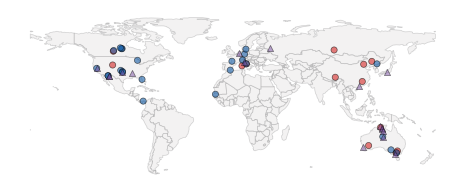

In [133]:


def make_map(ks_results):
    
    ks_color_dict = {"WL": '#155DA6',#'#4b8eeb',
                        "SA": '#D62927',#'#ed5a5a',
                        "V": '#000000'}
    ks_map = ks_results[['SITE_ID', 'category']].merge(meta[['SITE_ID', 'LOCATION_LAT', 'LOCATION_LONG']], how = 'left', on = 'SITE_ID')
    #ks_map['category'] = ks_map['category'].astype('category')
    #sorter = ['V', 'SA', 'WL']
    #ks_map['category'] = ks_map['category'].cat.set_categories([sorter])
    cmap = ListedColormap([ks_color_dict[group] for group in ks_map['category'].cat.categories])

    consistent = ks_map[ks_map['category'] != 'V']
    inconsistent = ks_map[ks_map['category'] == 'V']
    
    # Convert the DataFrame to a GeoDataFrame
    
    gdf_consistent = gpd.GeoDataFrame(consistent, geometry=gpd.points_from_xy(consistent.LOCATION_LONG, consistent.LOCATION_LAT))
    gdf_inconsistent = gpd.GeoDataFrame(inconsistent, geometry=gpd.points_from_xy(inconsistent.LOCATION_LONG, inconsistent.LOCATION_LAT))

    # Plot
    # Get the world data and filter out Antarctica
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[world['continent'] != 'Antarctica']

    #ax = world.boundary.plot(figsize=(2.3*2.5,1.5*2.5), linewidth=0.25, edgecolor='black')
    ax = world.boundary.plot(figsize=(2.3*2.5,1.5*2.5), linewidth=1, edgecolor = '#a7a7a8', facecolor = '#e8e6e6', lw = 0.5, alpha = 0.5, zorder = 1)

    gdf_consistent.plot(ax=ax, markersize=20, column='category', legend=False, cmap = cmap, edgecolor = 'black', lw = 0.5, alpha = 0.6)
    gdf_inconsistent.plot(ax=ax, markersize=20, marker = '^', column='category', legend=False, color = "#774E9F", edgecolor = 'black', lw = 0.5, alpha = 0.5)

    # Remove latitude-longitude markers
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)  # Remove the axis border

    plt.show()
    fig = ax.get_figure()
    return fig

fig = make_map(events_iqr.drop_duplicates(subset = 'SITE_ID'))
fig.savefig('figs_raw/FIG3_map.svg', format = 'svg', dpi = 300)


## Scatter plots

In [134]:
# Make colormaps
def truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''    
    cmapIn = plt.get_cmap(cmapIn)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))
    return new_cmap

cmap_mod = truncate_colormap(minval=.2, maxval=.8) 

In [100]:

x_min_dict = {
'pre_storm_swc':0,
'storm_length':0,
'SWC_F_MDS_1':0,
'WS_F_max':0,}


x_max_dict = {
'pre_storm_swc':100,
'storm_length':25,
'SWC_F_MDS_1':100,
'WS_F_max':10,}



In [101]:
def fig_scatter(event_df, columns, anomaly_column = 'actual - predicted (bootstrapped)', ks_group = 'all', max_days = 40, fit_to_quantiles = False, quantile_amount = 10, fig_title = None, ylims = None):
    
    
    if ks_group == 'all':
            df = event_df
            cmap = plt.cm.YlGnBu
            
    elif ks_group == 'WL':
            df = event_df[event_df['category'] == 'WL']
            cmap = plt.cm.Blues
    elif ks_group == 'SA':
            df = event_df[event_df['category'] == 'SA']
            cmap = plt.cm.Reds  
    elif ks_group == 'V':
            df = event_df[event_df['category'] == 'V']
            cmap = plt.cm.Purples
            #cmap = plt.cm.Greys
    else:
            raise ValueError(f"ks_group must be all, event < test, or event > test. Got {ks_group}")         

    cmap = truncate_colormap(cmapIn = cmap, minval=.18, maxval=1) 
            
    # Even number of columns
    num_cols = len(columns)
    if num_cols%2 != 0: raise ValueError("num_cols must be even.")
        
    fig, axs = plt.subplots(2, int(num_cols/2), dpi=300, figsize = (11,5)) #(6,10) figsize = (50,30)
    print(f"Fig size: {(3.75 * int(num_cols/2), 8)}")
    ax = axs.flatten()
    
    cols = columns + [anomaly_column]
    event_numeric = df[cols]
    x = event_numeric.columns
    y = anomaly_column
    for i in range(len(event_numeric.columns)):

        # Get the variable for the x axis, but don't make plot when column for anomaly is reached
        x_temp = x[i]
        if x_temp == anomaly_column: break
        
        if x_temp == 'swc_percentile_max':
                ax[i].set_xlim(95,100)
        if x_temp == 'day_no_rain_pre':
                ax[i].set_xlim(0,14)
                
        # Check if x_temp is in the x_min_dict and x_max_dict
        try:
                x_min = x_min_dict[x_temp]
                x_max = x_max_dict[x_temp]
                ax[i].set_xlim(x_min, x_max)
        except:
                x_min = 0
                
        if x[i] == 'day_no_rain_pre':
                sns.histplot(data = event_numeric, x = x_temp, y = y, ax = ax[i], stat = 'count', legend = True, cmap = cmap, vmin = 1, vmax = max_days, discrete = True)
        else:
                #ax[i].plot(event_numeric[x_temp], event_numeric[y], 'o', mfc = '#6781f5', mec = 'black', alpha = 0.3, markeredgewidth = 0.5)
                sns.histplot(data = event_numeric, x = x_temp, y = y, ax = ax[i], stat = 'count', legend = True, cmap = cmap, vmin = 1, vmax = max_days)
        
        event_many_factors_nonan = event_numeric[[x_temp,y]].dropna()
      
        x_regr = event_many_factors_nonan[x_temp].values
        y_regr = event_many_factors_nonan[y].values

        # Get m and b from polyfit
        m, b = np.polyfit(x_regr, y_regr, 1)
        ax[i].plot(x_regr, m*x_regr + b, '-', color = 'black', lw = 2)
        
        # Pearson r
        r, p = pearsonr(x_regr, y_regr)
        
        # Set x and y labels
        try:
                ax[i].set_xlabel(ylabels[cols[i]])
        except KeyError:
                ax[i].set_xlabel(cols[i])
                  
        ax[i].set_ylim(-6,3)
        
        if i == 0:
                ax[i].set_ylabel('Normalized\nevent anomaly')#\nnormalized by mean site GPP')
        elif i == (int(num_cols/2)):
                ax[i].set_ylabel('Normalized\nevent anomaly')#\nnormalized by mean site GPP')
        else:
                ax[i].set_ylabel('')
                
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(3))

        # Annotate plot 
        annotation ='$r$='+ str(round(r,2)) #+ '\nslope='+str(round(m,2)) # '$R^2$=' + str(round(r_sq,2))  + 
        plt.text(0.64, 0.87, annotation,
                horizontalalignment='left',
                verticalalignment='center',
                transform=ax[i].transAxes)

        # Optionally add title
        if fig_title is not None:
                ax[1].set_title(fig_title)

        plt.subplots_adjust(hspace=0.5)

    # Colorbar adjustments
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(1,max_days))
    cbar_ax = fig.add_axes([0.85, 0.6, 0.1, 0.25]) 
    #cbar_ax = fig.add_axes([0.85, 0.25, 0.1, 0.5])  # MIddle of 2 rows

    cbar_ax.set_frame_on(False)
    cbar_ax.get_xaxis().set_visible(False)
    cbar_ax.get_yaxis().set_visible(False)
    cbar = fig.colorbar(sm, ax=cbar_ax, orientation='vertical')
    cbar.set_label('Number of days')

    #plt.tight_layout(rect=[0, 0, 0.9, 1]) 

    return fig

matplotlib.rcParams.update({'font.size': 12})


Fig size: (15.0, 8)


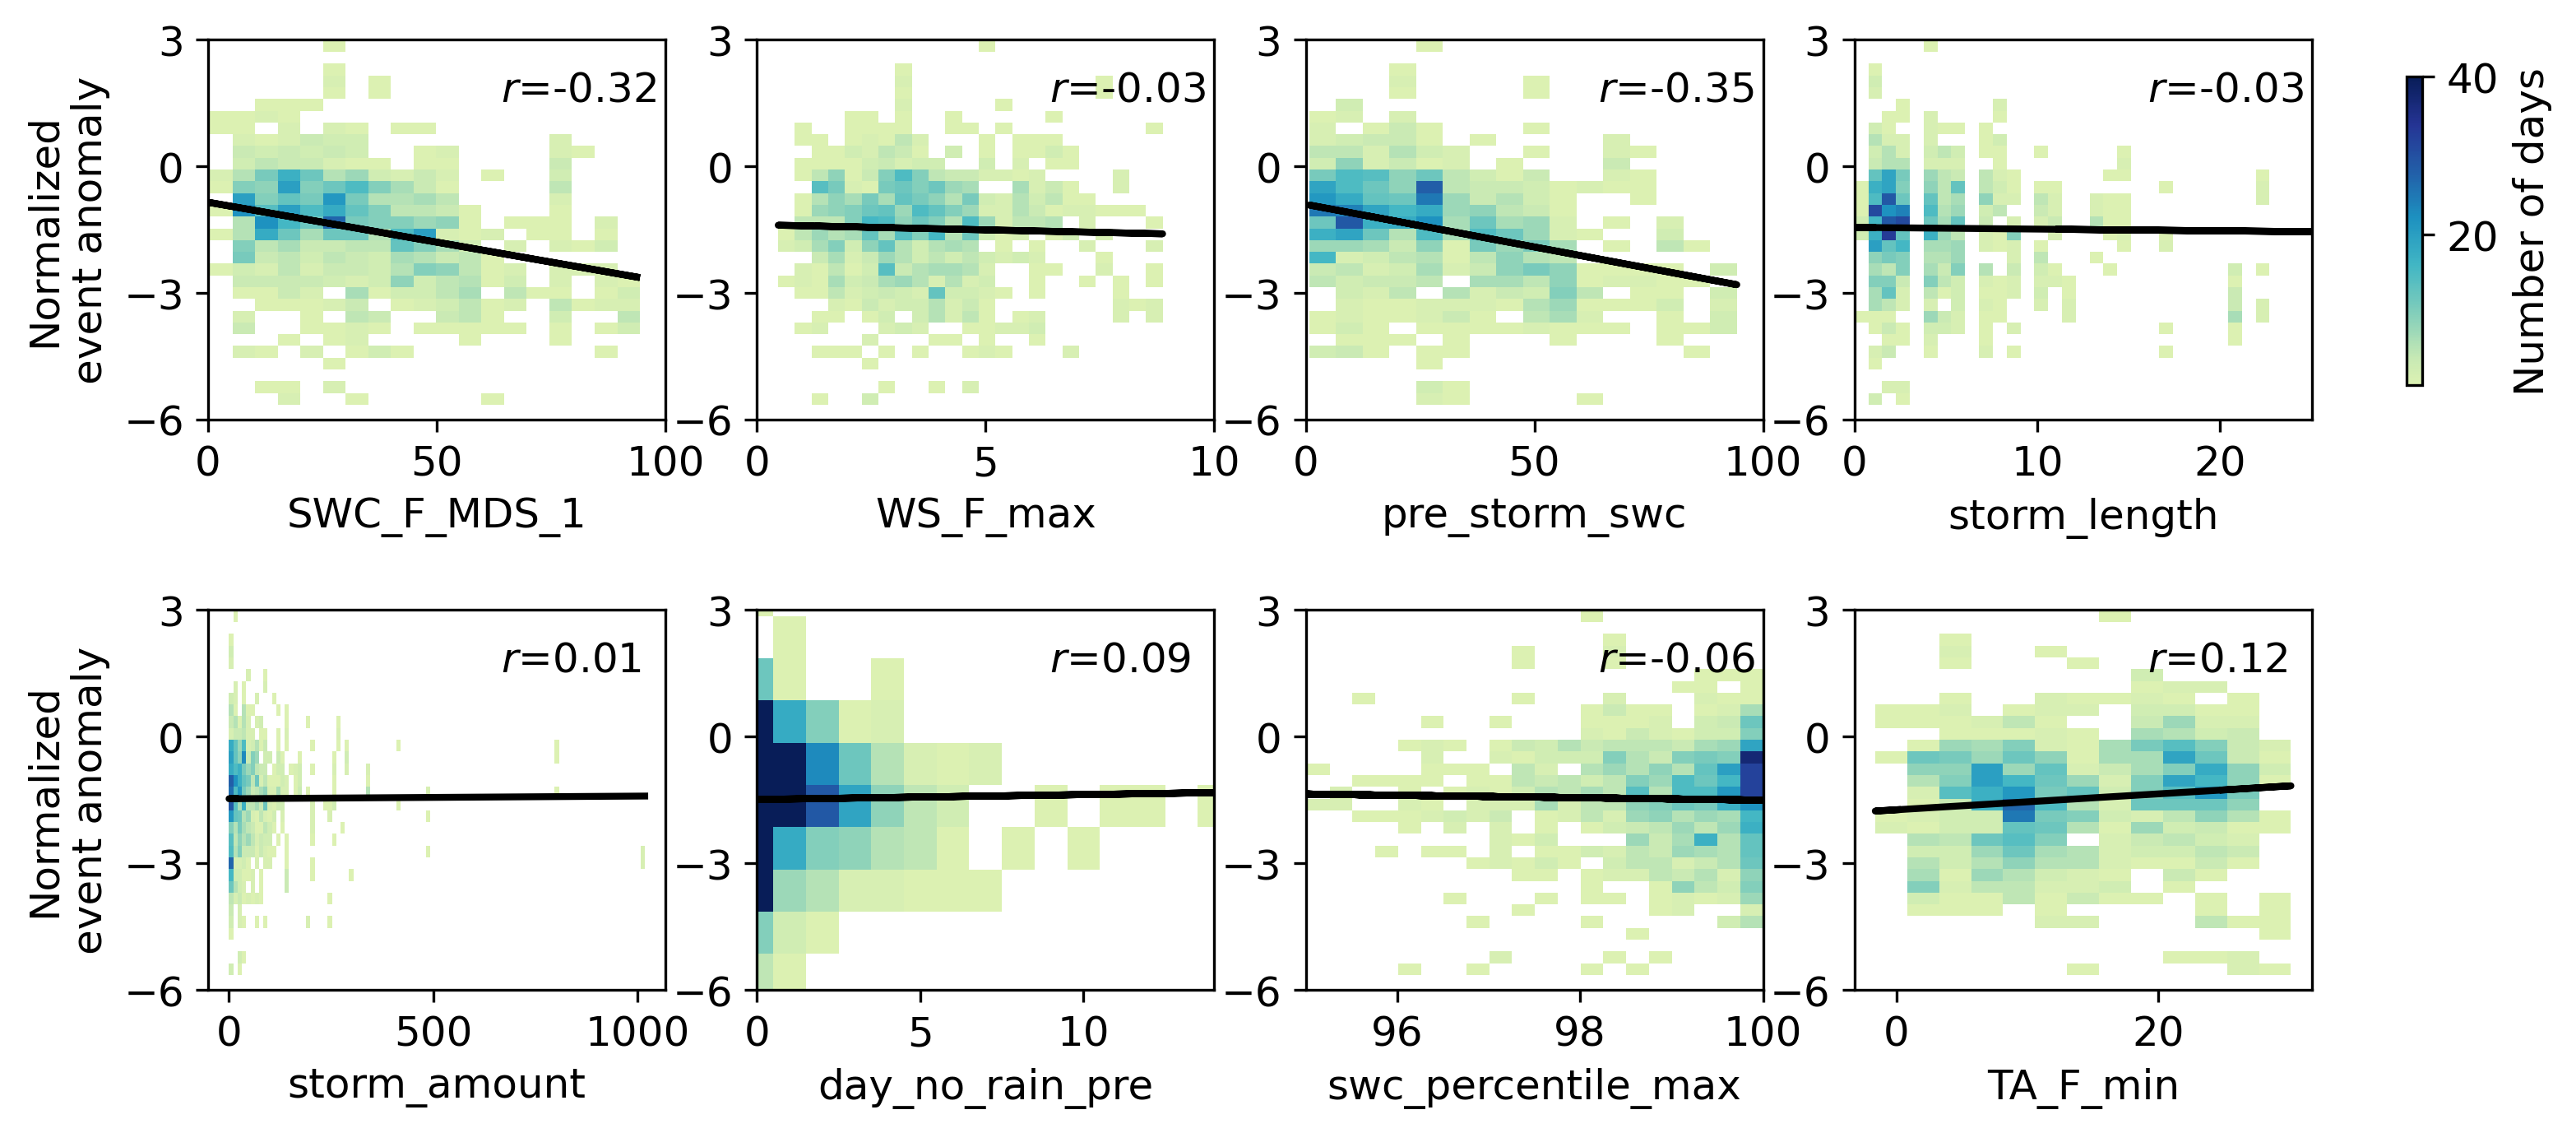

In [102]:

fig = fig_scatter(event_df = events_iqr, columns = ['SWC_F_MDS_1', 'WS_F_max', 'pre_storm_swc', 'storm_length',
                                                    'storm_amount', 'day_no_rain_pre', 'swc_percentile_max', 'TA_F_min'],
                  anomaly_column = 'anomaly_norm_gpp', ks_group = 'all', max_days = 40, fit_to_quantiles = False, quantile_amount = 1)

fig.savefig('figs_raw/SI_scatter_allsites.svg', format = 'svg', dpi = 300)



Fig size: (15.0, 8)


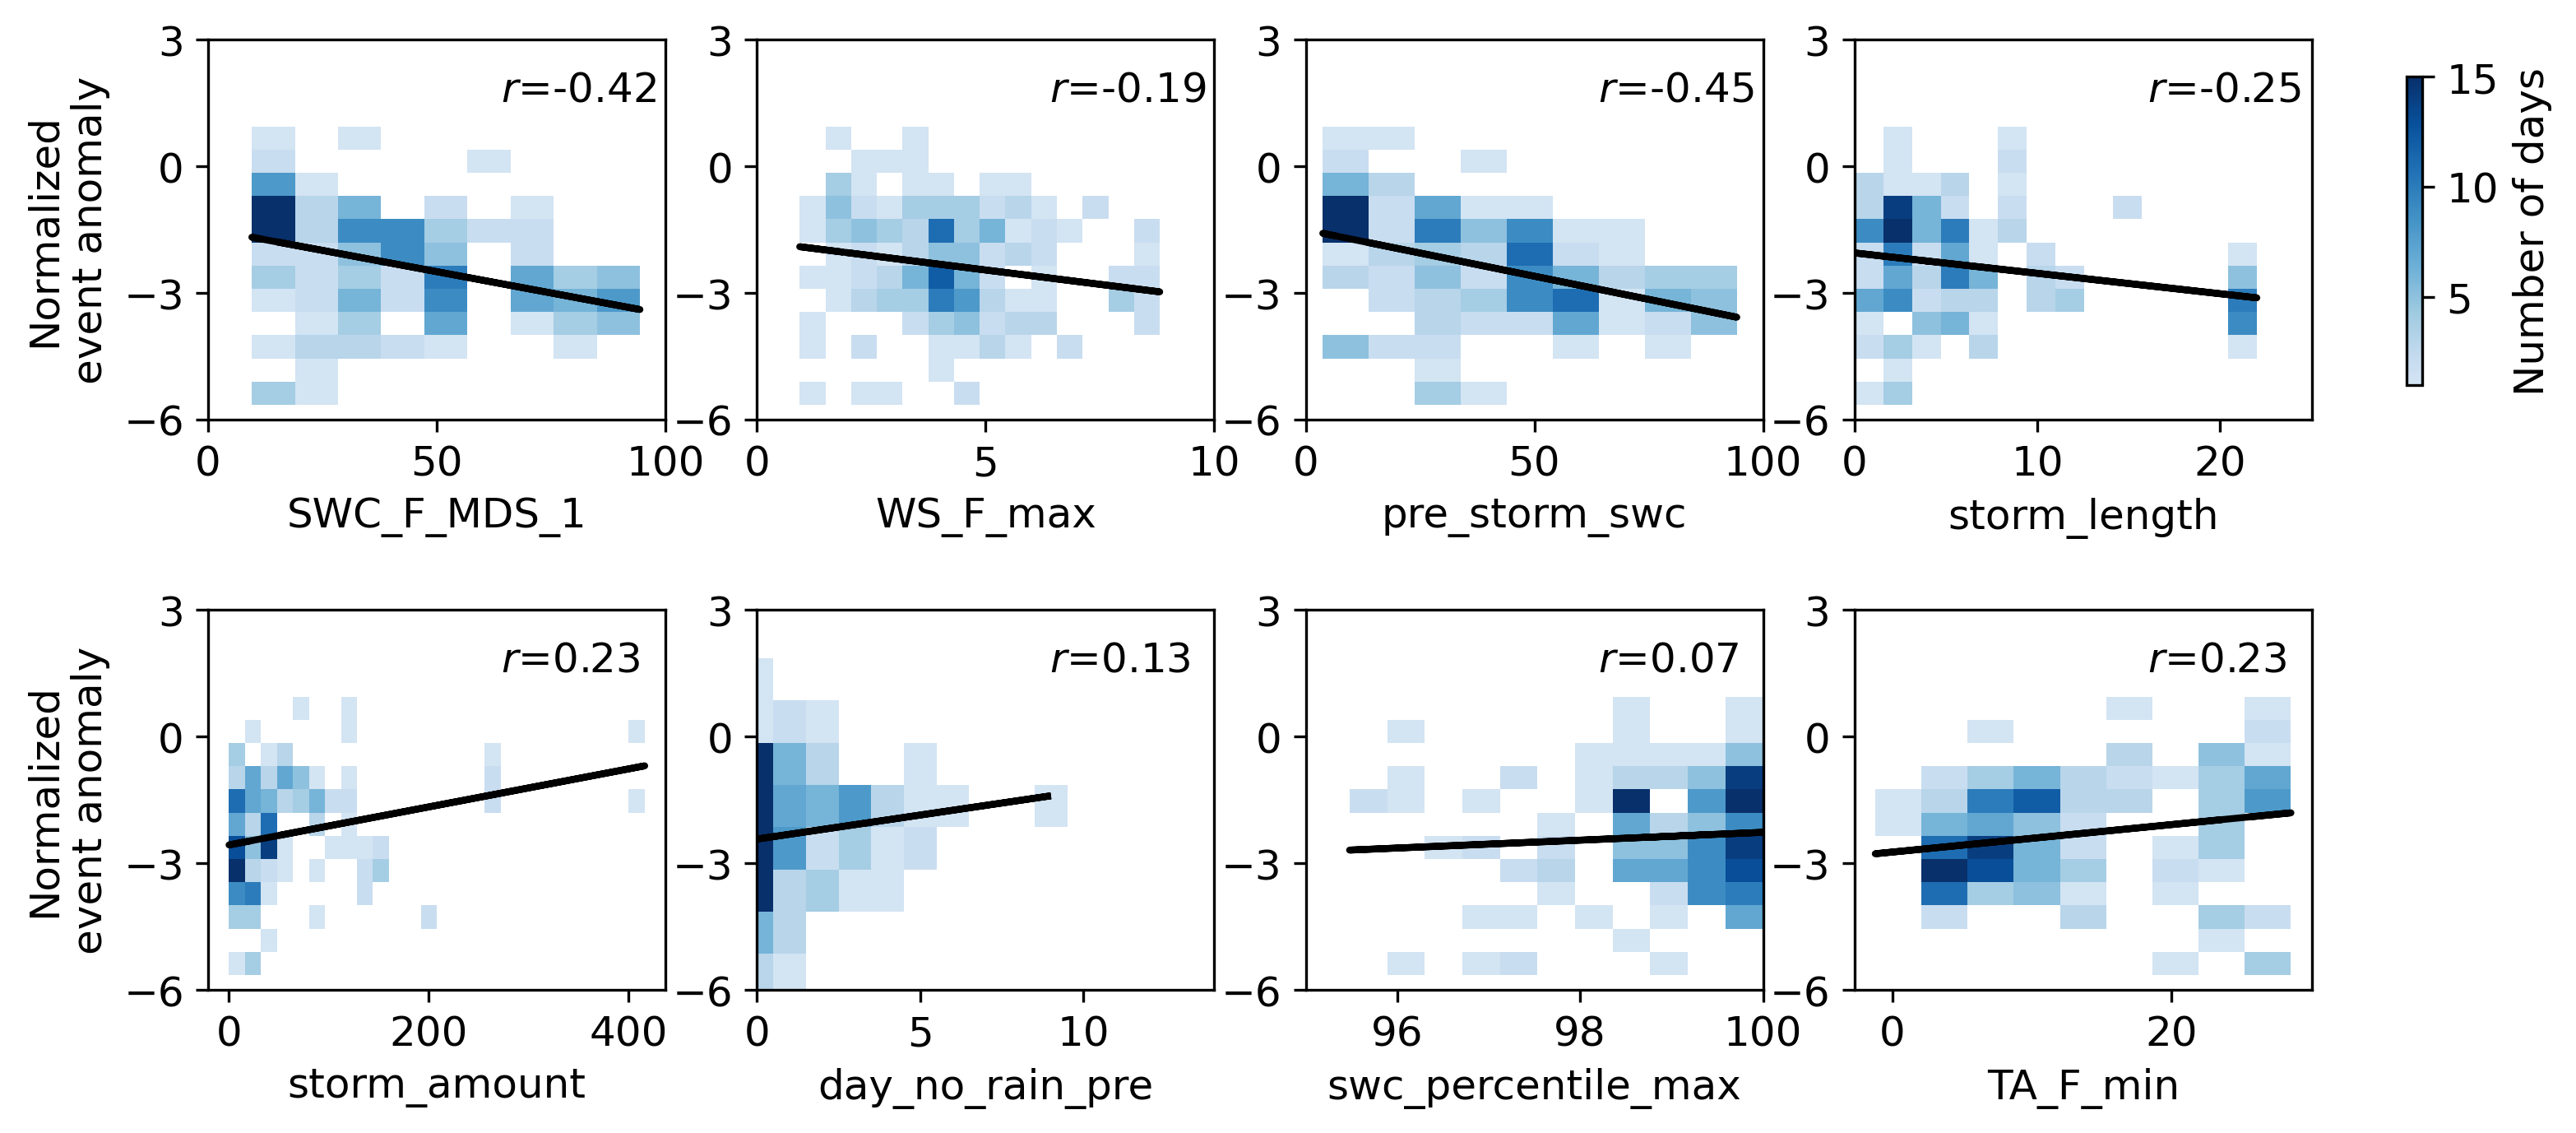

In [103]:

fig = fig_scatter(event_df = events_iqr, columns = ['SWC_F_MDS_1', 'WS_F_max', 'pre_storm_swc', 'storm_length',
                                                    'storm_amount', 'day_no_rain_pre', 'swc_percentile_max', 'TA_F_min'],
                  anomaly_column = 'anomaly_norm_gpp', ks_group = 'WL', max_days = 15, fit_to_quantiles = False, quantile_amount = 1)

fig.savefig('figs_raw/FIG3_scatterWL.svg', format = 'svg', dpi = 300)

Fig size: (15.0, 8)


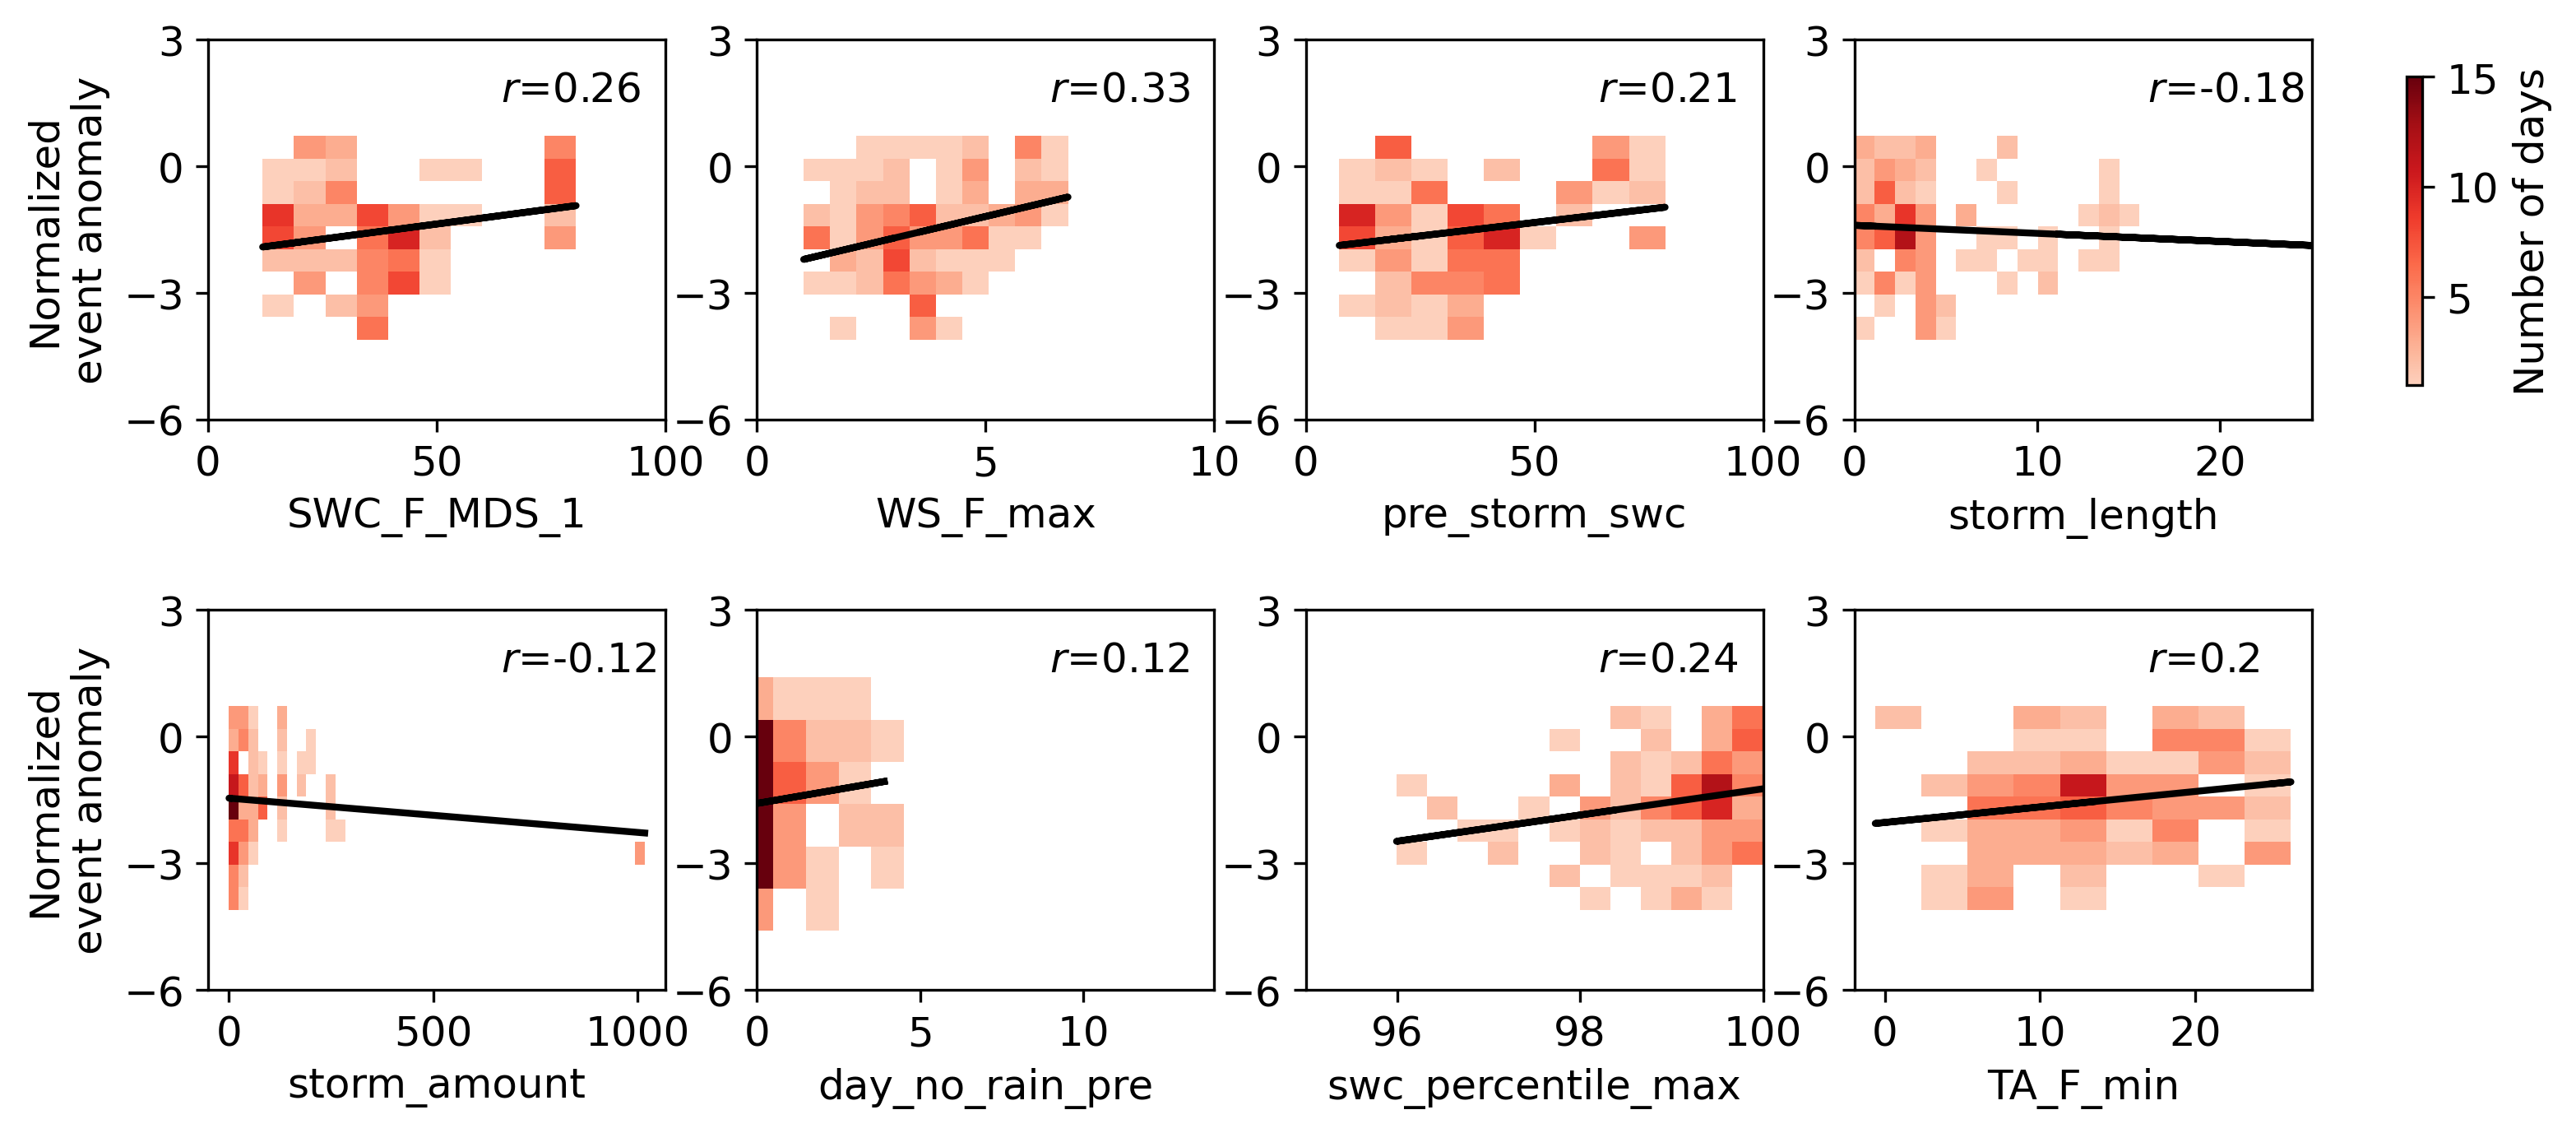

In [104]:

fig = fig_scatter(event_df = events_iqr, columns = ['SWC_F_MDS_1', 'WS_F_max', 'pre_storm_swc', 'storm_length',
                                                    'storm_amount', 'day_no_rain_pre', 'swc_percentile_max', 'TA_F_min'],
                  anomaly_column = 'anomaly_norm_gpp', ks_group = 'SA', max_days = 15, fit_to_quantiles = False, quantile_amount = 1)

fig.savefig('figs_raw/FIG3_scatterSA.svg', format = 'svg', dpi = 300)

Fig size: (15.0, 8)


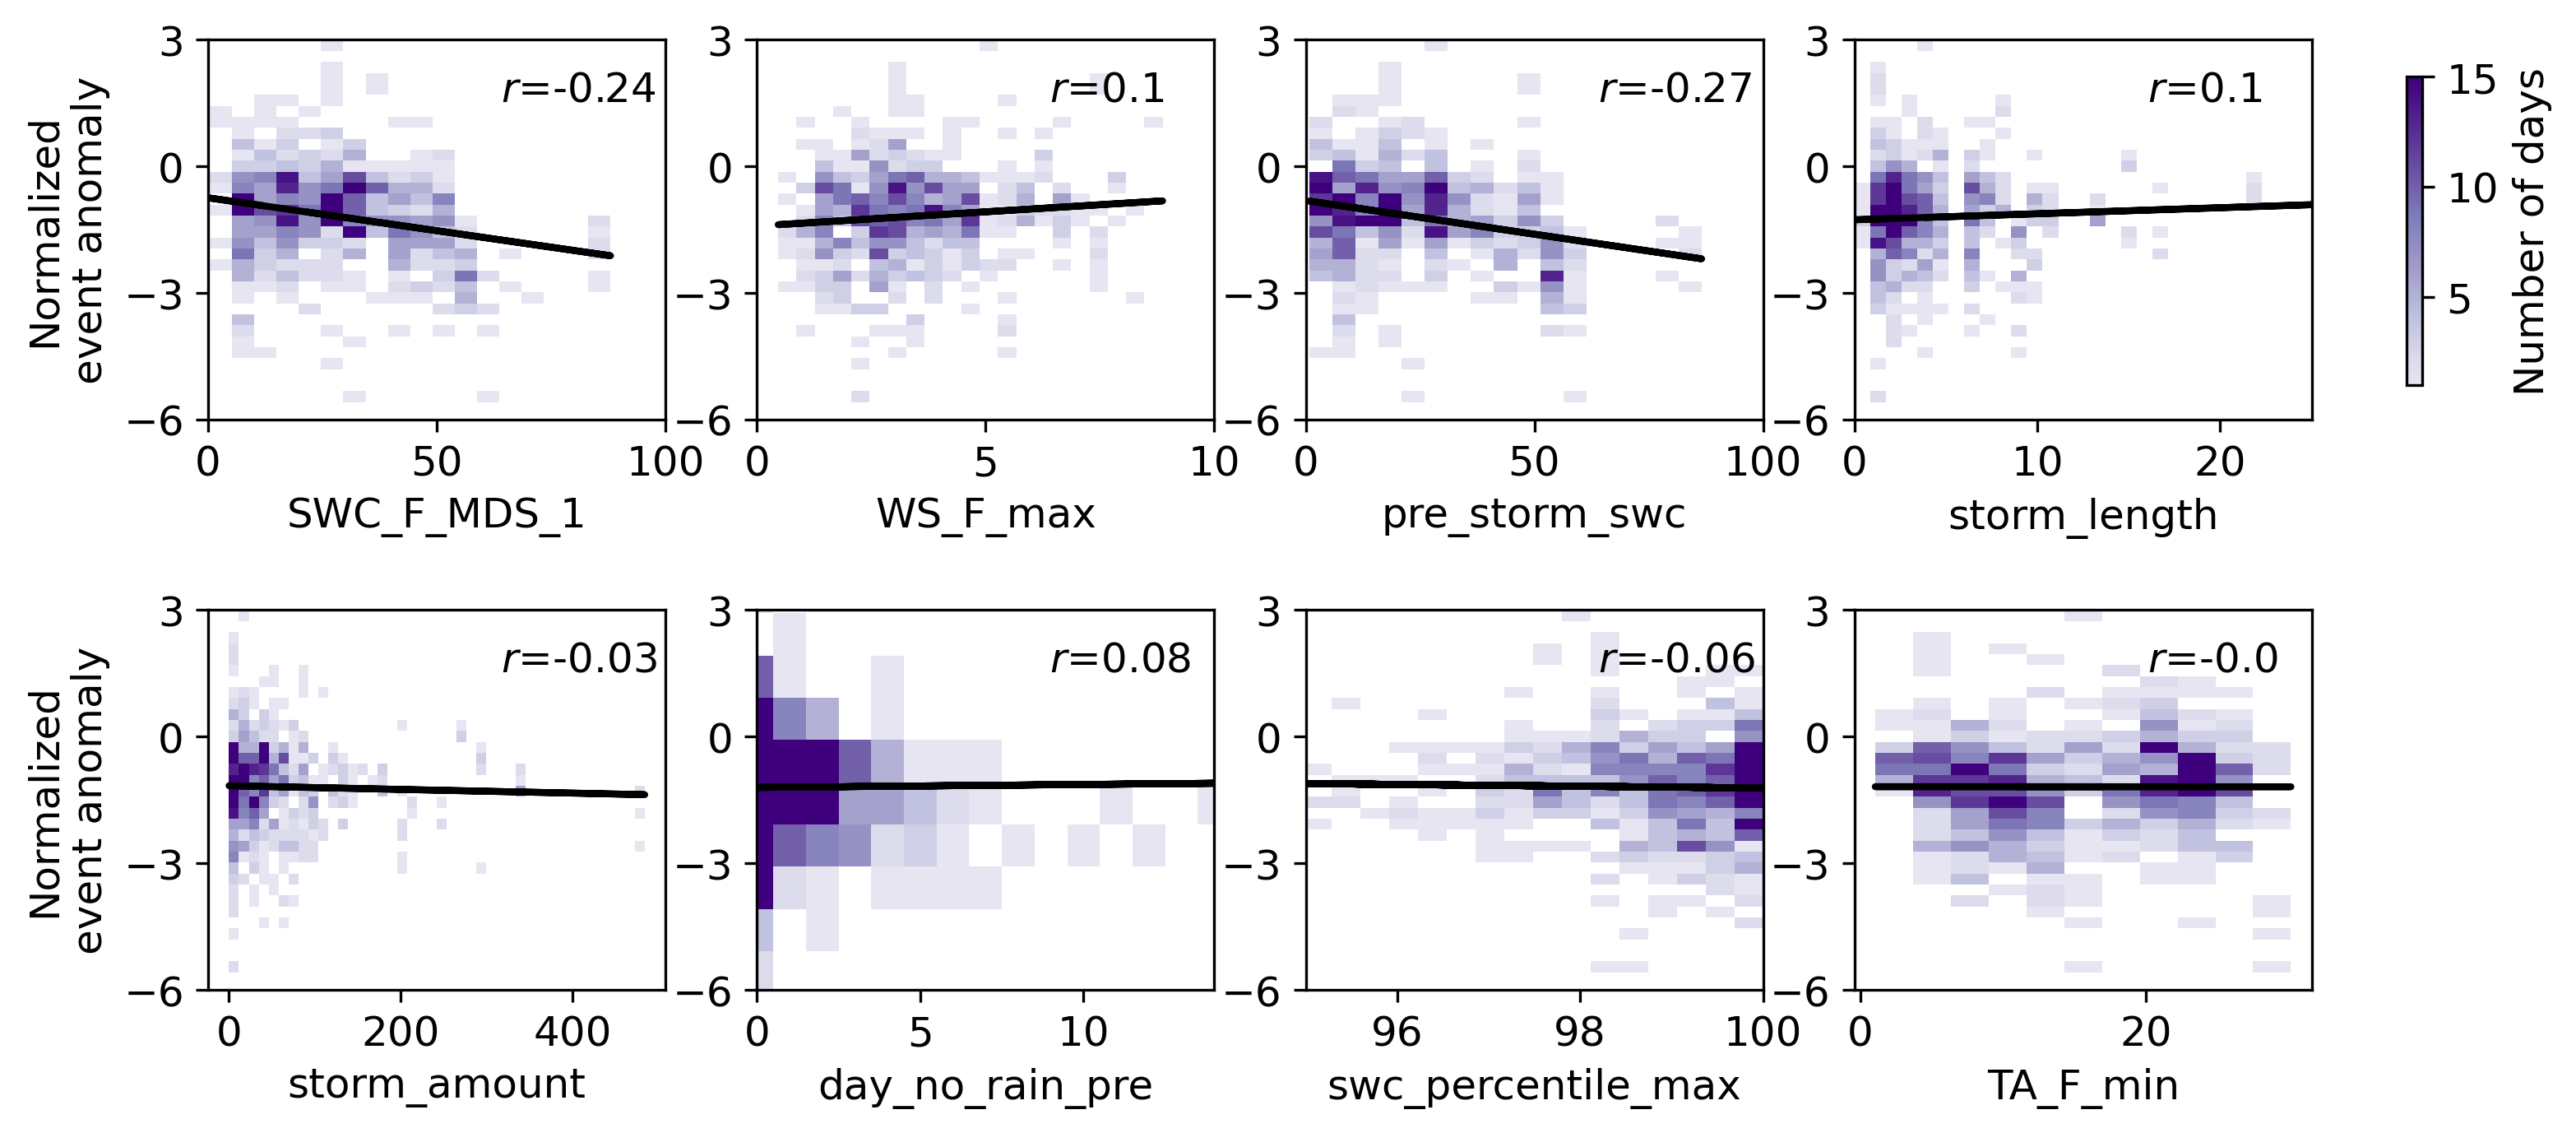

In [105]:

fig = fig_scatter(event_df = events_iqr, columns = ['SWC_F_MDS_1', 'WS_F_max', 'pre_storm_swc', 'storm_length',
                                                    'storm_amount', 'day_no_rain_pre', 'swc_percentile_max', 'TA_F_min'],
                  anomaly_column = 'anomaly_norm_gpp', ks_group = 'V', max_days = 15, fit_to_quantiles = False, quantile_amount = 1)

fig.savefig('figs_raw/FIG3_scatterV.svg', format = 'svg', dpi = 300)

# Build random forest to predict anomaly, and evaluate feature importance

In [106]:
# check cross correlation between storm and site feaures



cross_corr = events_iqr[['porosity', 'bdod_mean_alldepth', 'mean_lai', 'MAP_y', 'twi', 'pre_storm_swc', 'WS_F_max', 'storm_amount']].corr()
cross_corr.style.background_gradient(cmap='coolwarm')

,porosity,bdod_mean_alldepth,mean_lai,MAP_y,twi,pre_storm_swc,WS_F_max,storm_amount
porosity,1.000000,-1.000000,0.529950,0.410594,0.015934,0.329375,-0.167313,0.078033
bdod_mean_alldepth,-1.000000,1.000000,-0.529950,-0.410594,-0.015934,-0.329375,0.167313,-0.078033
mean_lai,0.529950,-0.529950,1.000000,0.537551,-0.185487,0.451562,-0.041435,0.003374
MAP_y,0.410594,-0.410594,0.537551,1.000000,-0.085199,0.248931,-0.180736,0.424354
twi,0.015934,-0.015934,-0.185487,-0.085199,1.000000,-0.079109,-0.137200,0.085465
pre_storm_swc,0.329375,-0.329375,0.451562,0.248931,-0.079109,1.000000,0.033394,-0.077568
WS_F_max,-0.167313,0.167313,-0.041435,-0.180736,-0.137200,0.033394,1.000000,0.020691
storm_amount,0.078033,-0.078033,0.003374,0.424354,0.085465,-0.077568,0.020691,1.000000


In [107]:


# Build random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV


In [69]:
groups = {'porosity':"site", 'twi':"site", 'MAT_y':"site", "MAP_y":"site", 'soil_skew':"site", 'elv':"site", 'hnd':"site",
       'bdod_mean_alldepth':"site", 'ksat_surface':"site", 'aridity_new':"site", "WTD":"site","mean_lai":"site",
       'WS_F_max':"storm", 'SWC_F_MDS_1':"storm", 'storm_amount':"storm", 'storm_length':"storm", 'P_F_lag_sum':"RF",
       'GPP_April':"RF", 'LAI':"RF", 'VPD_F':"RF", 'RH':"RF", 'WS_F':"RF", 
       'pre_storm_swc':"storm", "swc_over_porosity":"storm"}

In [249]:
ylabels = {'hnd': "HAND (m)",
    'elv': "Elevation (m)",
    'swc_99_min_90': "99th percentile SWC\n(SWC\u2089\u2089 - SWC\u2089\u2080) (mm)",
    'bdod_mean_alldepth' : "Bulk density (g/kg)",
    'ksat_surface': "log Ksat\nof 0-5cm (mm/s)",
    'sand': "Sand (%)",
    'clay': "Clay (%)",
    'event_over_test_days': 'Percentage of high-quality data\nclassified as pluvial event (%)',
    'swc_99': "SWC at the 99th\ndaily percentile [m3/m3]",
    'storm_amount_pluvial_event_mean': 'Mean event-associated\nstorm amount (mm)',
    'storm_length_pluvial_event_mean': 'Mean event-associated\ncontinuous storm length (days)',
    'storm_amount_percentile':"Storm P amount\n(percentile)",
    'storm_length_percentile':"Storm duration\n(percentile)",
    'soil_skew': "Soil moisture\ndistribution skew",
    'aridity_new': "PET/P (annual)",
    'PET': "PET (mm)",
    'MAP_y':"MAP (mm)",
    "koppen_category":"Koppen Group",
    "SWC_F_MDS_1":"SWC (-)",
    "WS_F_max":"Max storm\nwind speed (m/s)",
    "SWC_F_MDS_1_max":"Max storm SWC [-]",
    "swc_over_max": "SWC (fraction of max)",
    "swc_over_mean": "SWC (fraction of mean)",
    "swc_percentile":"SWC (percentile at site)",
    "swc_percentile_max": "Max storm SWC\n(percentile)",
    "actual":"GPP",
    "wind_percentile_max":"Max storm wind speed\n(percentile)",
    'porosity':"Soil porosity (%)",
    "storm_amount":"Storm precip. amount (mm)",
    "storm_length":"Storm duration (days)",
    "twi":"Topographic wetness index [-]",
    "day_no_rain_pre":"Days of no rain prior to event",
    "swc_max_minus_pre":"Max storm SWC -\nSWC before storm (mm)",
    "pre_storm_swc":"SWC 2 days\nbefore storm (-)",
    "mean_lai":"Mean LAI",
    "MAT_y":"MAT (C)"}

## pull in results from featureimportance_DTpartitioned.py

In [7]:
perf_storm = pd.read_csv('runs/rf_explain_anomaly/performances_storm_smallersearch.csv') #('runs/rf_explain_anomaly/performances_storm_notest.csv')
perf_site = pd.read_csv('runs/rf_explain_anomaly/performances_site_smallersearch.csv') #('runs/rf_explain_anomaly/performances_site_notest.csv')
perf_all = pd.read_csv('runs/rf_explain_anomaly/performances_all_smallersearch.csv') #('runs/rf_explain_anomaly/performances_all_notest.csv')

importances_storm = pd.read_csv('runs/rf_explain_anomaly/importances_storm_smallersearch.csv') #('runs/rf_explain_anomaly/importances_storm_notest.csv')
importances_site = pd.read_csv('runs/rf_explain_anomaly/importances_site_smallersearch.csv') #('runs/rf_explain_anomaly/importances_site_notest.csv')
importances_all = pd.read_csv('runs/rf_explain_anomaly/importances_all_smallersearch.csv') #('runs/rf_explain_anomaly/importances_all_notest.csv')
importances = importances_all

perf_storm_max = perf_storm[perf_storm['r2'] == perf_storm['r2'].max()]
perf_site_max = perf_site[perf_site['r2'] == perf_site['r2'].max()]
perf_all_max = perf_all[perf_all['r2'] == perf_all['r2'].max()]

print(f"Storm: {perf_storm_max['r2'].values[0]}, Site: {perf_site_max['r2'].values[0]}, All: {perf_all_max['r2'].values[0]}")


Storm: 0.3986348752865732, Site: 0.5590485138813551, All: 0.6197760256942825


In [15]:
0.5590485138813551/0.6197760256942825, 0.3986348752865732/0.6197760256942825

(0.9020170040541671, 0.643191828596494)

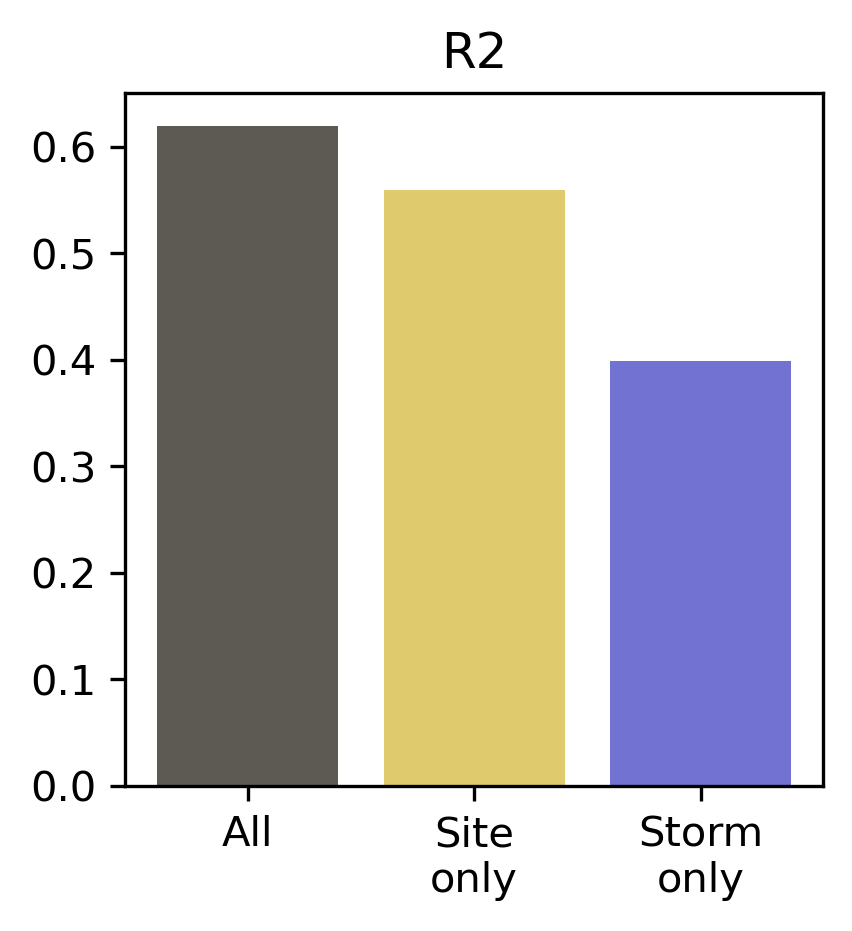

In [8]:
plt.figure(dpi=300, figsize = (3, 3))
plt.bar(x = ['All', 'Site\nonly', 'Storm\nonly'], height = [perf_all_max.r2.max(), perf_site_max.r2.max(), perf_storm_max.r2.max()], color = [ '#5C5A52', '#DFCA6D', '#7272D2'])
#plt.title('R2 of RF model using subset of features')
plt.title("R2")#, rotation = 0, labelpad = 40)
plt.savefig('figs_raw/FI2_rfimportances_barinset_oneparameterset.svg', dpi = 300)

In [9]:
soil = ['porosity', 'bdod_mean_alldepth', 'ksat_surface', 'soil_skew']
topo = ['elv', 'twi', 'hnd']
climate = ['MAP_y', 'MAT_y', 'aridity_new']
veg = ['mean_lai']

storm_soil = ['SWC_F_MDS_1', 'pre_storm_swc']
storm_intensity = ['storm_amount', 'storm_length']
wind = ['WS_F_max']
rf_features = ['TA_F', 'VPD_F','RH']

type_dict = {"porosity":"soil",
             "bdod_mean_alldepth":"soil",
                "ksat_surface":"soil",
                "soil_skew":"soil",
                "elv":"topo",
                "twi":"topo",
                "hnd":"topo",
                "MAP_y":"climate",
                "MAT_y":"climate",
                "aridity_new":"climate",
                "mean_lai":"veg",
                "SWC_F_MDS_1":"storm_soil",
                "pre_storm_swc":"storm_soil",
                "storm_amount":"storm_intensity",
                "storm_length":"storm_intensity",
                "WS_F_max":"wind",
                "TA_F":"rf_features",
                "VPD_F":"rf_features",
                "RH":"rf_features"}
# replace "feature" column with type
importances['type'] = importances['feature'].map(type_dict)

In [10]:
#best_r2s = perf_all[perf_all['r2'] > 0.616]['r2'].values()
best_importances = importances[importances['r2'] > 0.616]
best_importances

,Unnamed: 0,importance,feature,group,r2,type
42,3,0.179064,mean_lai,site,0.618152,veg
43,0,0.101872,porosity,site,0.618152,soil
44,4,0.097327,pre_storm_swc,storm,0.618152,storm_soil
45,1,0.090076,elv,site,0.618152,topo
46,2,0.087088,MAP_y,site,0.618152,climate
...,...,...,...,...,...,...
548,2,0.097994,MAP_y,site,0.618218,climate
549,4,0.091936,pre_storm_swc,storm,0.618218,storm_soil
550,0,0.069684,ksat_surface,site,0.618218,soil
551,6,0.056308,WS_F_max,storm,0.618218,wind


In [13]:
importances.r2.min(), importances.r2.max()

(0.5593814151387312, 0.6197760256942825)

In [12]:
best_importances.r2.unique().min(), best_importances.r2.unique().max()

(0.6170140813259208, 0.6197760256942825)

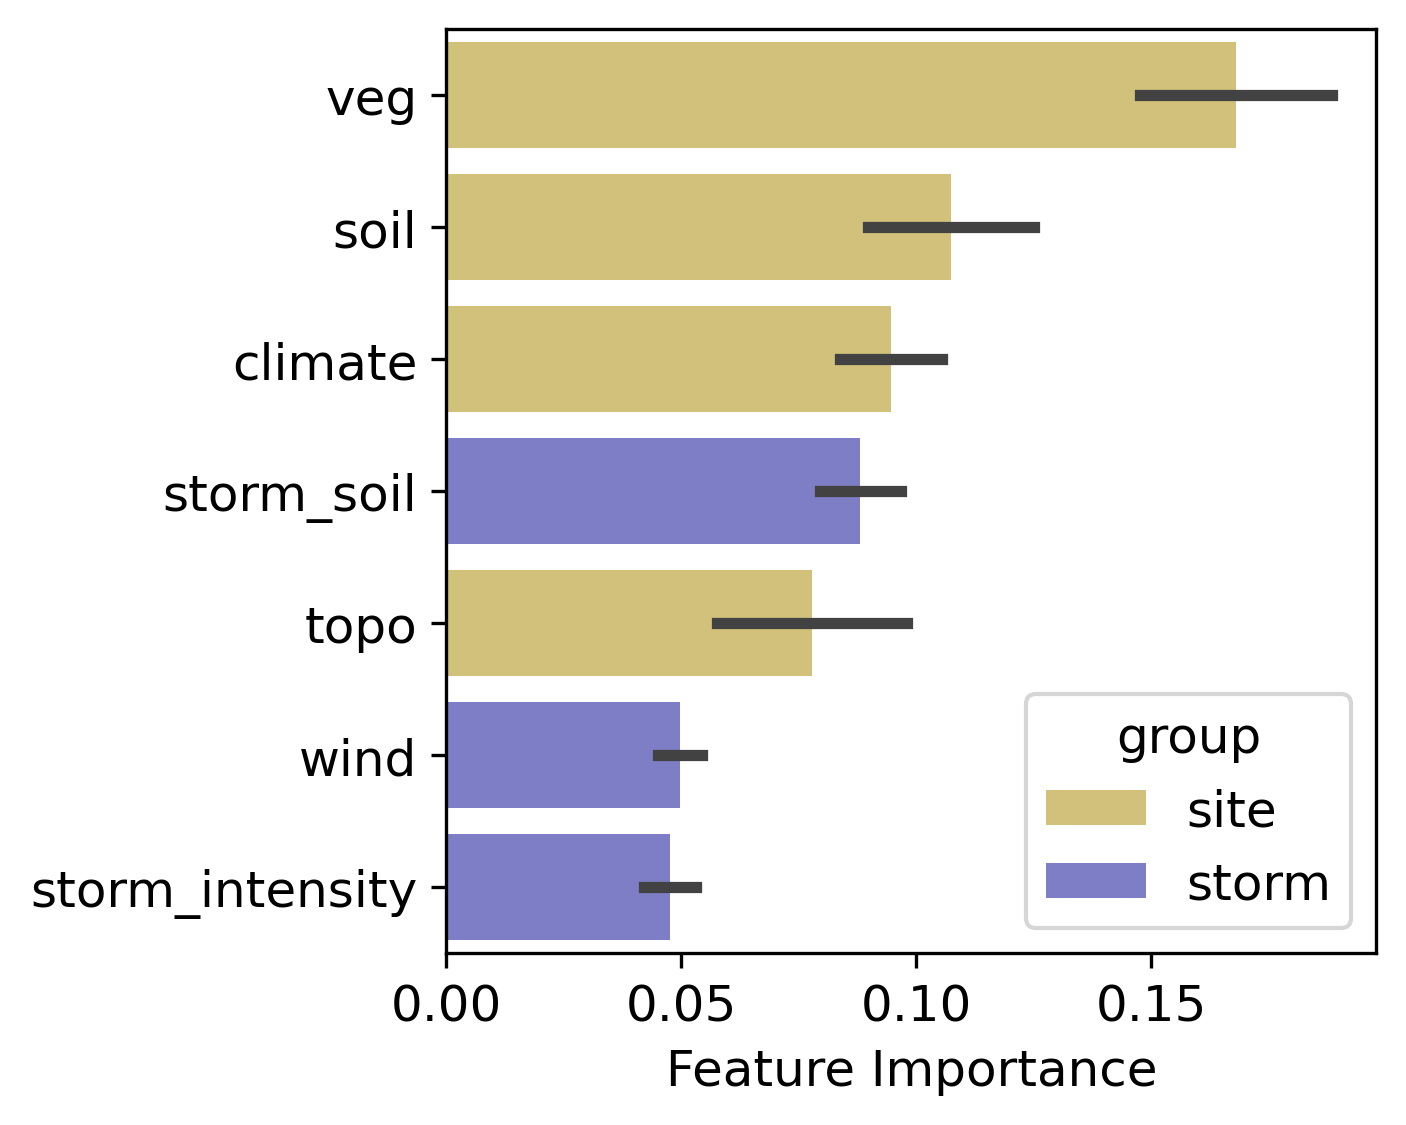

In [240]:
# top ten performing models
#top_10_r2s = importances_onemodel.drop_duplicates(subset = 'r2').sort_values(by = 'r2', ascending = False)[0:10]['r2'].values
##perf_all_best = importances_onemodel[importances_onemodel['r2'].isin(top_10_r2s)].sort_values(by='r2', ascending = False)

mean_importance = best_importances.groupby('type')['importance'].mean().reset_index().sort_values(by='importance', ascending=False)

plt.figure(dpi=300, figsize = (4,4))
sns.barplot(data = best_importances.sort_values(by='importance', ascending=False), x = 'importance', y = 'type', hue = 'group', palette = ['#DFCA6D', '#7272D2'], dodge = False, errorbar = "sd", order = mean_importance.sort_values(by = 'importance', ascending = False)['type'])
#plt.title("Best model from every combination of possible features")
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.savefig('figs_raw/FIG2_rfimportances_dt_TOP10_ONEPARAMETERSET.svg', dpi = 300)
plt.show()
plt.close()

In [198]:
ylabels = {'hnd': "HAND (m)",
    'elv': "Elevation (m)",
    'swc_99_min_90': "99th percentile SWC\n(SWC\u2089\u2089 - SWC\u2089\u2080) (mm)",
    'bdod_mean_alldepth' : "Bulk density (g/kg)",
    'ksat_surface': "log Ksat\nof 0-5cm (mm/s)",
    'sand': "Sand (%)",
    'clay': "Clay (%)",
    'event_over_test_days': 'Percentage of high-quality data\nclassified as pluvial event (%)',
    'swc_99': "SWC at the 99th\ndaily percentile [m3/m3]",
    'storm_amount_pluvial_event_mean': 'Mean event-associated\nstorm amount (mm)',
    'storm_length_pluvial_event_mean': 'Mean event-associated\ncontinuous storm length (days)',
    'storm_amount_percentile':"Storm P amount\n(percentile)",
    'storm_length_percentile':"Storm duration\n(percentile)",
    'soil_skew': "Soil moisture\ndistribution skew",
    'aridity_new': "PET/P (annual)",
    'PET': "PET (mm)",
    'MAP_y':"MAP (mm)",
    "koppen_category":"Koppen Group",
    "SWC_F_MDS_1":"SWC (-)",
    "WS_F_max":"Max storm\nwind speed (m/s)",
    "SWC_F_MDS_1_max":"Max storm SWC [-]",
    "swc_over_max": "SWC (fraction of max)",
    "swc_over_mean": "SWC (fraction of mean)",
    "swc_percentile":"SWC (percentile at site)",
    "swc_percentile_max": "Max storm SWC\n(percentile)",
    "actual":"GPP",
    "wind_percentile_max":"Max storm wind speed\n(percentile)",
    'porosity':"Soil porosity (%)",
    "storm_amount":"Storm precip. amount (mm)",
    "storm_length":"Storm duration (days)",
    "twi":"Topographic wetness index [-]",
    "day_no_rain_pre":"Days of no rain prior to event",
    "swc_max_minus_pre":"Max storm SWC -\nSWC before storm (mm)",
    "pre_storm_swc":"SWC 2 days\nbefore storm (-)",
    "mean_lai":"Mean LAI"}

In [199]:
importances.columns

Index(['Unnamed: 0', 'importance', 'feature', 'group', 'r2', 'type'], dtype='object')

In [200]:
best = importances[importances['r2'] == importances['r2'].max()]

In [202]:
best

,Unnamed: 0,importance,feature,group,r2,type
266,3,0.154669,mean_lai,site,0.619776,veg
267,2,0.099667,aridity_new,site,0.619776,climate
268,0,0.099299,bdod_mean_alldepth,site,0.619776,soil
269,4,0.090715,pre_storm_swc,storm,0.619776,storm_soil
270,1,0.089420,elv,site,0.619776,topo
271,6,0.052917,WS_F_max,storm,0.619776,wind
272,5,0.052301,storm_amount,storm,0.619776,storm_intensity


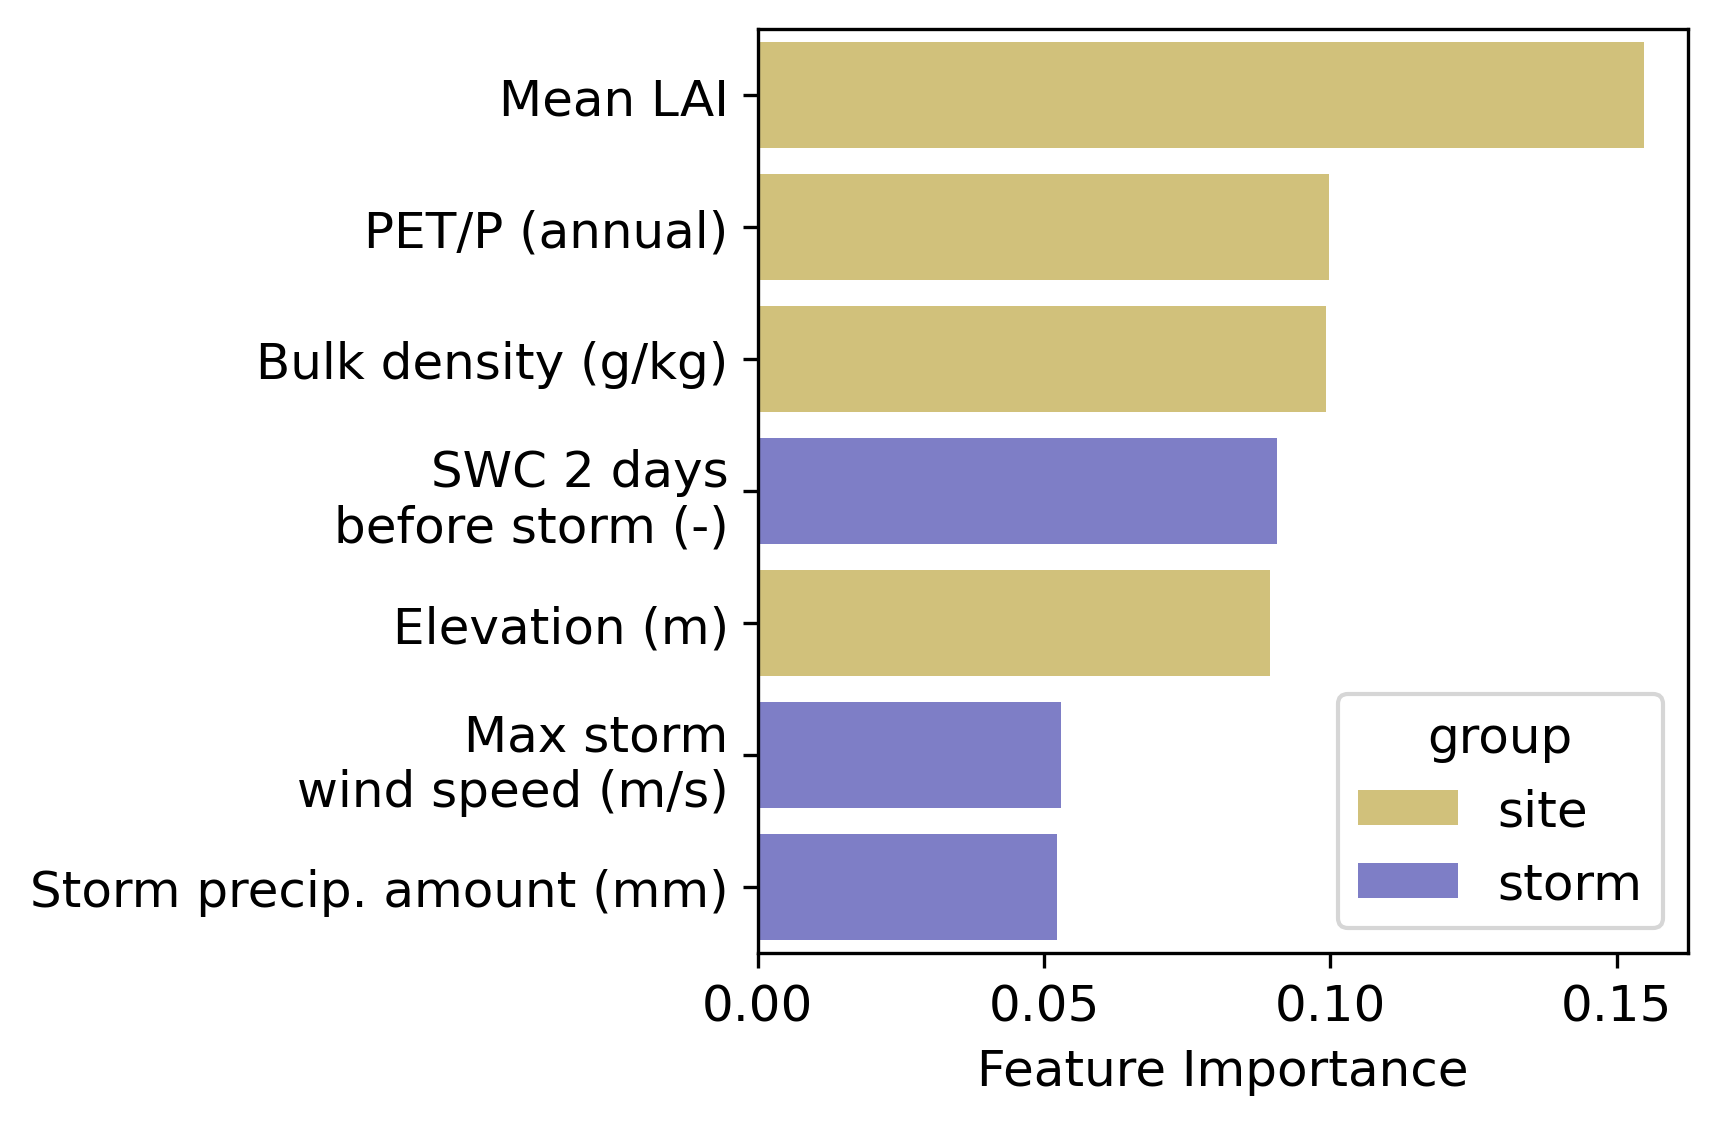

In [201]:
plt.figure(dpi=300, figsize = (4,4))
sns.barplot(data = best.replace(ylabels), x = 'importance', y = 'feature',hue = 'group', palette = ['#DFCA6D', '#7272D2'], dodge = False)
#plt.title("Best model from every combination of possible features")
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.savefig('figs_raw/FIG2_rfimportances.svg', dpi = 300)

## Feature cross correlation

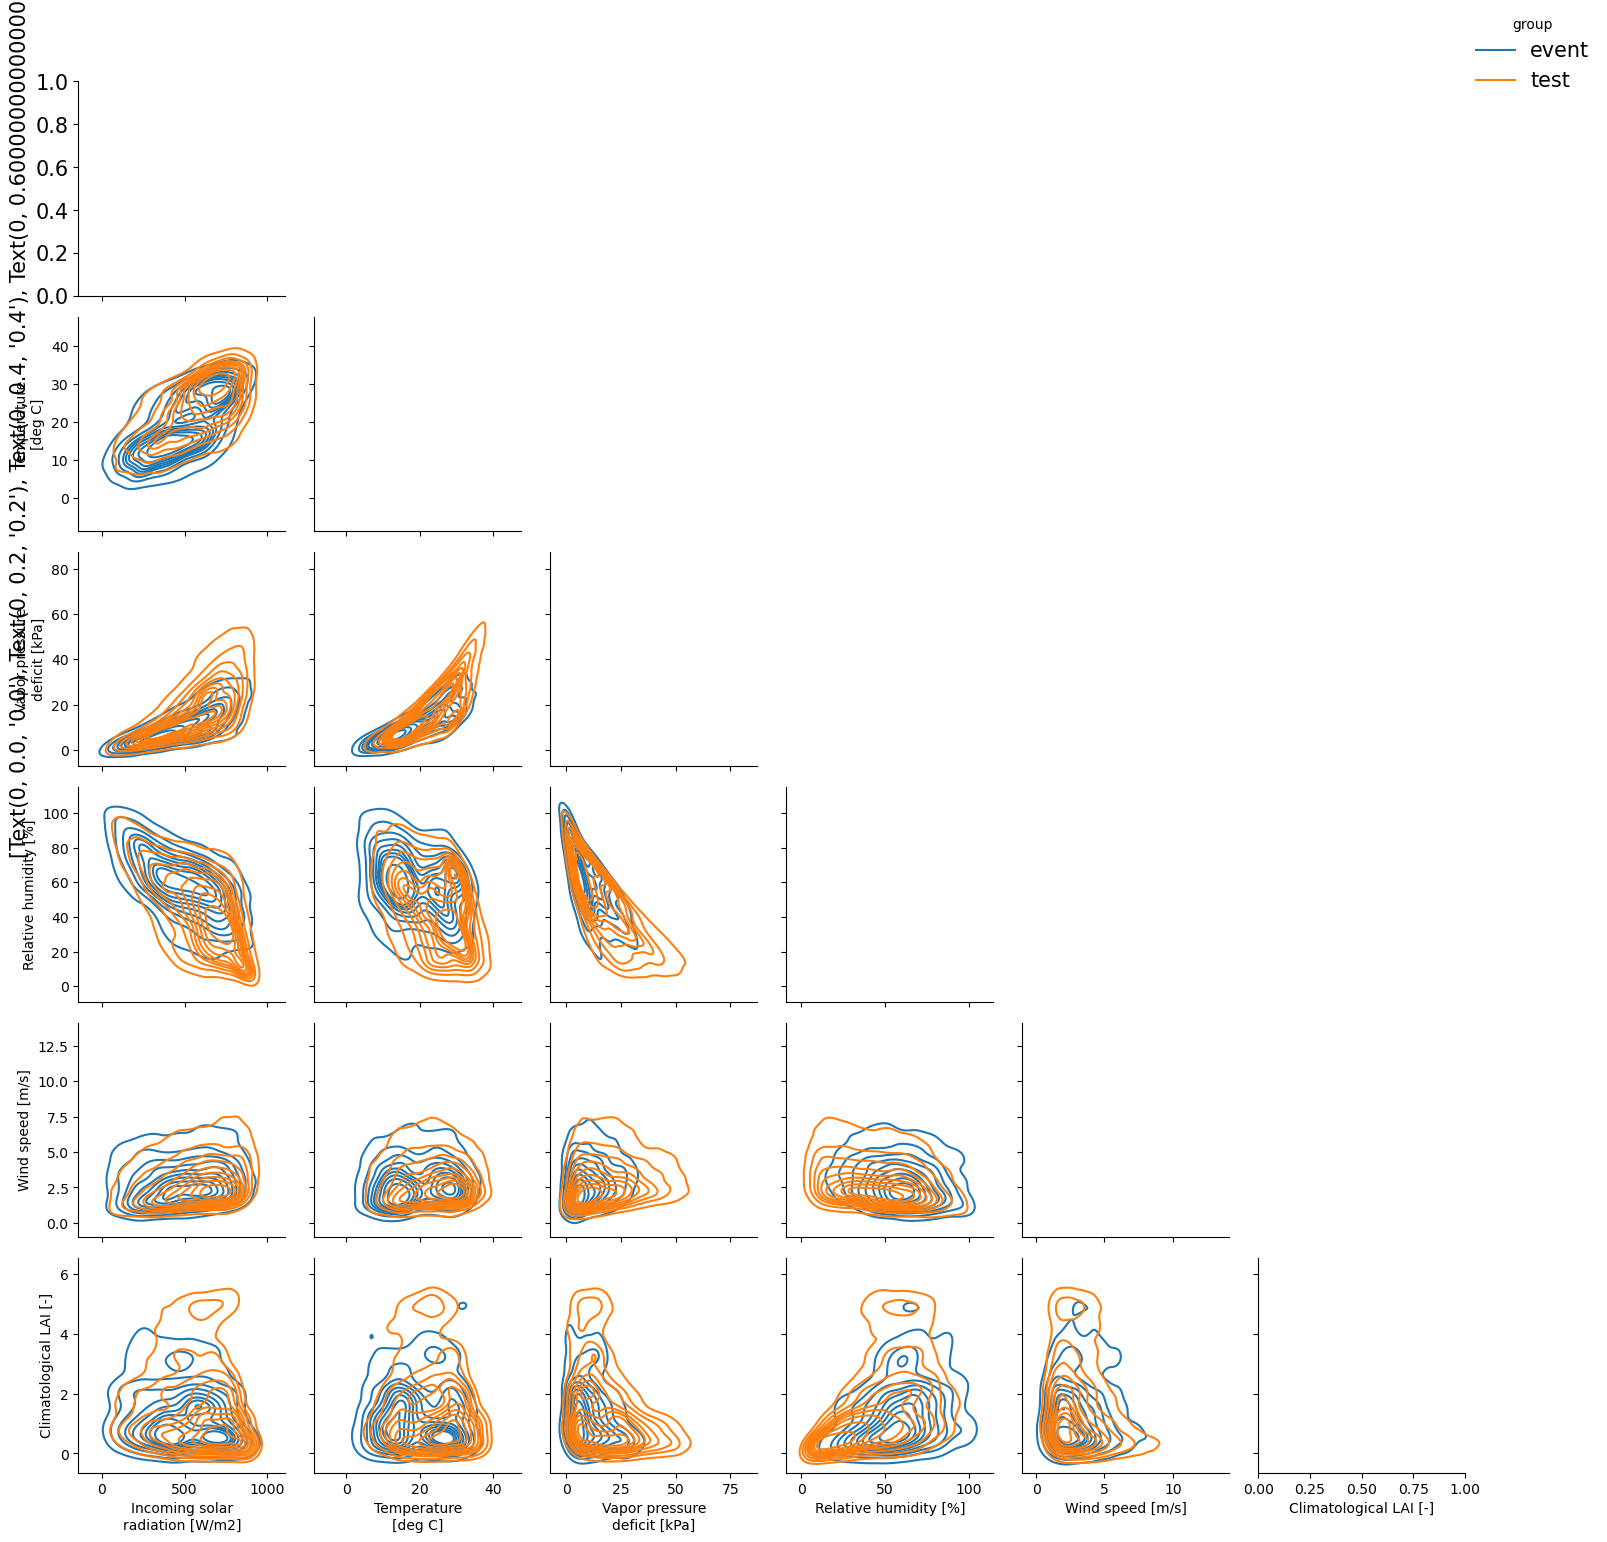

In [255]:
event_small = event[['SW_IN_F', 'TA_F',
       'VPD_F', 'RH', 'WS_F', 'LAI']]

test_small = test[['SW_IN_F', 'TA_F',
       'VPD_F', 'RH', 'WS_F', 'LAI']]


event_small['group'] = 'event'
test_small['group'] = 'test'
merged = pd.concat([event_small, test_small])

# get rid of LAI blip
merged.loc[merged['LAI']>=10,'LAI'] = merged.LAI.mean()


names = {'SW_IN_F' : "Incoming solar\nradiation [W/m2]", 
         'TA_F': "Temperature\n[deg C]",
         'RH': "Relative humidity [%]",
         'WS_F': "Wind speed [m/s]",
         'LAI': "Climatological LAI [-]",
         'P_F_lag_sum': "Recent cumulative\nprecipitation [mm]",
         "VPD_F": "Vapor pressure\ndeficit [kPa]"}
         #'April_GPP': "Mean GPP, 1st week of April (gC m-2 d-1)"}


merged = merged.rename(columns = names)
merged.head()

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

#mpl.rcParams["axes.labelsize"] = 14

g = sns.PairGrid(merged, hue = "group")
g.map_lower(sns.kdeplot, common_norm = False)
g.map_diag(hide_current_axis)
g.map_upper(hide_current_axis)
g.add_legend(fontsize = 14, bbox_to_anchor = (1, 1))

#g._legend.set_title("Data Group")
#g._legend.get_title().set_fontsize('15') 
for text in g._legend.get_texts():
    text.set_fontsize('15')  
for ax, name in zip(g.axes.flat, merged['group'].unique()):
    #ax.set_title('')  # Remove the title
    ax.set_xlabel(ax.get_xticklabels(), fontsize = 15); 
    ax.set_ylabel(ax.get_yticklabels(), fontsize = 15); 
    ax.tick_params(labelsize=15);
    
#plt.show()
plt.savefig('figs_raw/SI_featdist.svg', format = 'svg', dpi = 300)

## Random forest PDPs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
rng = np.random.default_rng()
from sklearn.inspection import partial_dependence
import ast

In [ ]:
# Import data
randomforest = pd.read_csv('runs/RF/RF_DT_targetscaled/performance.csv')
random_state = 1
features = ['SW_IN_F', 'TA_F', 'RH', 'WS_F', 'LAI', 'P_F_lag_sum', 'GPP_April']
train_all = pd.read_csv('output_findevents/v3/allsites_training_dd_clipped.csv')
sites = randomforest.SITE_ID.unique()
pdp_all = pd.DataFrame()
for site_name in sites:

    train_one_site = train_all[train_all['SITE_ID'] == site_name]

    X = train_one_site[features]
    y = train_one_site['GPP_DT_VUT_REF']


    # Minmax scaler
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Get the forest structure
    randomforest_site = randomforest[randomforest['SITE_ID'] == site_name]
    best_model = randomforest_site['best_params'].unique()[0]
    best_model = ast.literal_eval(best_model) # convert from string to dictionary

    # Initialize and fit model
    estimator = RandomForestRegressor(n_estimators = best_model['n_estimators'],
                                    min_samples_split = best_model['min_samples_split'],
                                    min_samples_leaf = best_model['min_samples_leaf'],
                                    max_features = best_model['max_features'],
                                    max_depth = best_model['max_depth'],
                                    bootstrap = best_model['bootstrap']).fit(X,y)

    # Get PDP results
    for i in range(len(features)):
        pdp_results = partial_dependence(estimator, X, [i])
        pdp_temp = pd.DataFrame()
        pdp_temp['x_scaled'] = pdp_results['values'][0]
        pdp_temp['pdp'] = pdp_results['average'][0]
        pdp_temp['x_name'] = features[i]
        pdp_temp['SITE_ID'] = site_name

        # Unscale the X
        unscaling_df = pd.DataFrame(columns = features)
        unscaling_df[features[i]] = pdp_results['values'][0]
        unscaling_df = pd.DataFrame(scaler.inverse_transform(unscaling_df), columns = features)
        pdp_temp['x_unscaled'] = unscaling_df[features[i]].values
        
        pdp_all = pd.concat([pdp_all, pdp_temp])


In [ ]:
train_all[train_all['LAI']>10][['SITE_ID', 'day', 'LAI']].SITE_ID.unique()

In [ ]:
meta = pd.read_csv('metadata_total.csv')

pdp_all = pdp_all.merge(meta[['SITE_ID', 'IGBP']])

In [ ]:
# change the names to the full name for x_name
pdp_all.x_name.unique()

In [ ]:
names = {
    'SW_IN_F': "Incoming shortwave\nsolar radiation [W m$^{-2}$]",
    'TA_F': "Temperature\n[$^{\circ}$C]",
    'RH': "Relative humidity [%]",
    'WS_F': "Wind speed [m s$^{-1}$]",
    'LAI': "Climatological leaf area index [-]",
    'P_F_lag_sum': "Recent cumulative\nprecipitation [mm]",
    "VPD_F": "Vapor pressure\ndeficit [kPa]",
    "GPP_April": "Mean annual GPP, first week of April [gC m$^{-2}$ d$^{-1}$]"
}
pdp_all = pdp_all.replace({"x_name":names})
pdp_all.head()

In [ ]:
igbp_names = {
    "ENF": "Evergreen needleleaf forest",
    "EBF": "Evergreen broadleaf forest",
    "DNF": "Deciduous needleleaf forest",
    "DBF": "Deciduous broadleaf forest",
    "MF": "Mixed forest",
    "CSH": "Closed shrubland",
    "OSH": "Open shrubland",
    "WSA": "Woody savanna",
    "SAV": "Savanna",
    "GRA": "Grassland",
    "WET": "Wetlands",
    "CRO": "Croplands",
    "URB": "Urban",
    "NAT": "Natural",
    "SNW": "Snow and ice",
    "WAT": "Water bodies"
    
}

pdp_all = pdp_all.replace({"IGBP":igbp_names})
pdp_all.head()

In [ ]:
# pick one site from each landcover type
sites_to_pick = pdp_all.groupby('IGBP')['SITE_ID'].last().reset_index()['SITE_ID'].values
 
pdp_all['site_name'] = pdp_all['IGBP'] + ' (' + pdp_all['SITE_ID'] + ')'

single_site = pdp_all[pdp_all['SITE_ID'].isin(sites_to_pick)]
g = sns.relplot(data = single_site, x = "x_unscaled", y = "pdp", col = "x_name", hue = 'site_name',
            col_wrap = 3, kind = 'line', facet_kws = {'sharex':False, 'sharey':True})
g._legend.set_title("IGBP Type (Name of example site)")
g._legend.get_title().set_fontsize('15')  # for legend title

for text in g._legend.get_texts():
    text.set_fontsize('15')  # for legend text
for ax, name in zip(g.axes.flat, pdp_all['x_name'].unique()):
    ax.set_title('')  # Remove the title
    ax.set_xlabel(name, fontsize = 15)  # Set the xlabel to the column name
    ax.set_ylabel('GPP Prediction [gC m$^{-2}$ d$^{-1}$]', fontsize = 15)  # Set the xlabel to the column name
    ax.tick_params(labelsize=15)
    
legend = g._legend
legend.set_bbox_to_anchor((0.7, 0.18))  # (x, y) where x, y > 1 will move the legend further to the right
#plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.savefig('figs_raw/SI_rf_pdps.png')
